### Imports

In [ ]:
!pip install matplotlib-label-lines==0.3.6

In [ ]:
!pip install corner

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.ticker as mticker

from mpl_toolkits.mplot3d import Axes3D

mpl.rc('font', family='serif', size=22)
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['xtick.color'] = '#575757'
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['ytick.color'] = '#575757'
mpl.rcParams['hatch.linewidth'] = 2.0

import io
import itertools
from labellines import *

from scipy.optimize import minimize
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import corner

import astropy.units as u
from astropy.table import Table

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from platform import python_version

print(python_version())

3.7.13


Make a custom colormap for $P_{\rm orb}$

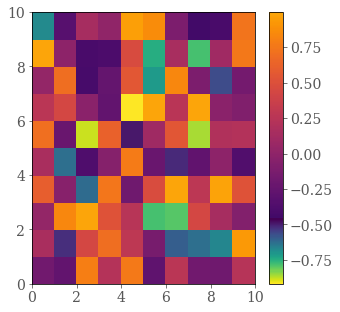

In [ ]:
import matplotlib.colors as mcolors

plt.figure(figsize=(5,5))

data = np.random.rand(10,10) * 2 - 1

# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.viridis_r(np.linspace(0., 1, 62))
colors2 = plt.cm.inferno(np.linspace(0.2, 0.8, 194))

# combine them and build a new colormap
colors = np.vstack((colors1, colors2))
cv_map = mcolors.LinearSegmentedColormap.from_list('all_cvmap', colors)

# now create a map for the period gap
gap_map = mcolors.LinearSegmentedColormap.from_list('gap_cvmap', cv_map(np.linspace(0.143, 0.294, 256)))

plt.pcolor(data, cmap=cv_map)
plt.colorbar()

Make a custom colormap for $G_{\rm BP}$ count https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

In [ ]:
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

In [ ]:
def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

hex_list = ['#ffffff', '#ff8c64','#610061']
obs_map = get_continuous_cmap(hex_list)

## VSX CVs --> *Gaia* Crossmatch

I propagated a 20" *Gaia* match backwards to J2000.00 using `epoch_prop_pos` in the default *Gaia* Archive ADQL functions. I then crossmatched this to the VSX CVs with a 1.5" radius. I take the *Gaia* neighborhood around each VSX CVs-Gaia crossmatch member to remove any sources that have neighbors within 2". The following file is the result of that ADQL Query.

In [ ]:
xmatch_df = pd.read_csv('/content/drive/MyDrive/cv_paper/data/vsx_edr3_xmatch.csv')

In [ ]:
xmatch_df.columns

Index(['name', 'type', 'period', 'u_period', 'solution_id', 'designation',
       'source_id', 'random_index', 'ref_epoch', 'ra',
       ...
       'r_hi_geo', 'dr2_phot_g_mean_mag', 'dr2_bp_rp',
       'dr2_phot_g_mean_flux_error', 'dr2_phot_g_mean_flux',
       'dr2_phot_bp_mean_flux_error', 'dr2_phot_bp_mean_flux',
       'dr2_phot_rp_mean_flux_error', 'dr2_phot_rp_mean_flux',
       'dr2_phot_bp_n_obs'],
      dtype='object', length=115)

In [ ]:
xmatch_df['gen_type'] = np.zeros(len(xmatch_df))

In [ ]:
cols = np.concatenate([['name', 'type', 'period', 'u_period', 'gen_type'], xmatch_df.columns.values[4:]])

In [ ]:
xmatch_df['gen_type'].loc[(xmatch_df['type'].str.contains('UG'))] = 'UG'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [ ]:
xmatch_df['gen_type'].loc[(xmatch_df['type'].str.contains('NL'))] = 'NL'

In [ ]:
xmatch_df['gen_type'].loc[(xmatch_df['type'].str.contains('AM'))] = 'AM'

In [ ]:
xmatch_df['gen_type'].loc[(xmatch_df['type'].str.contains('DQ'))] = 'DQ'

In [ ]:
xmatch_df['gen_type'].loc[(xmatch_df['type'].str.contains('NA')) |
                          (xmatch_df['type'].str.contains('NB')) |
                          (xmatch_df['type'].str.contains('NR'))] = 'CN'

We limit the VSX CVs-Gaia crossmatch to: 
1. Objects that have no neighbors within 2"
2. 1.1 hr < $P_{orb}$ < 8 hr
3. `parallax_over_error` > 8
4. `phot_g_mean_flux_over_error` > 10
4. `astrometric_n_good_obs_al` > 8

In [ ]:
vsx_df = xmatch_df.loc[(xmatch_df['period']*24 < 8) & (xmatch_df['period']*24 > 1.1) &
                       (xmatch_df['parallax_over_error'] > 8) & 
                       (xmatch_df['phot_g_mean_flux_over_error'] > 10) &
                       (xmatch_df['astrometric_n_good_obs_al'] > 8) ]

In [ ]:
vsx_df = vsx_df.sort_values(by='bp_rp')

In [ ]:
print(len(vsx_df))
print(len(vsx_df.loc[vsx_df['period']*24 < 3]))

623
339


Text(0, 0.5, 'Frequency')

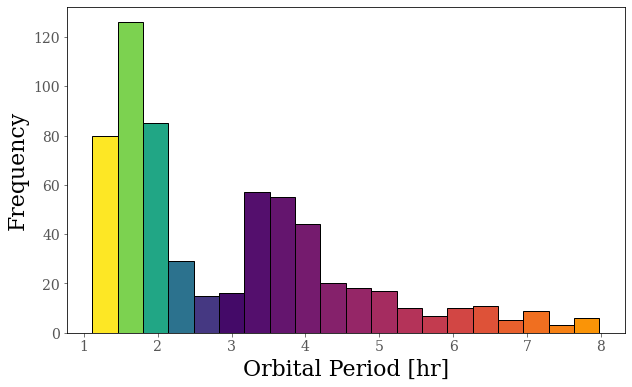

In [ ]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(vsx_df['period']*24, bins=20,
                            fc='Tomato', ec='k')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cv_map(i/20))

plt.xlabel('Orbital Period [hr]', fontsize=22)
plt.ylabel('Frequency', fontsize=22)
# plt.axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

## Fit a Linear Regression to the $P_{orb}$-CMD Relationship

Linear regression follows the general form of $Y=\beta X$, where $X$ is a matrix populated by columns of observables, and $\beta$ are the regression coefficients.

We'll be following this general model, using `pymc3`:
$P_{orb} \sim \beta_0 + \beta_X M_G + \beta_Y (G_{BP}-G_{RP}) + \beta_{XY} M_G \cdot (G_{BP}-G_{RP})$ 
Using `pymc3`, we model each $X_i$ as an independent variable in order to incorporate its uncertainty. We divide each observable by the sample median in order to allow for more accurate regression calculation.

We start by removing any Classical Novae from the fit.

In [ ]:
len(vsx_df.loc[(vsx_df['gen_type'] != 'CN')])

611

In [ ]:
no_cn_mask = (vsx_df['gen_type'] != 'CN')

In [ ]:
p_orb = (vsx_df['period']*24).loc[no_cn_mask]
abs_g = (vsx_df['phot_g_mean_mag'] - 5*np.log10(vsx_df['r_med_geo']) + 5).loc[no_cn_mask]
bp_rp = (vsx_df['bp_rp']).loc[no_cn_mask]

p_orb_med = np.median(p_orb)
abs_g_med = np.median(abs_g)
bp_rp_med = np.median(bp_rp)

In [ ]:
#faint end of lower cone line
print(bp_rp.loc[(abs_g > 12) & (bp_rp > 0.5)].values,abs_g.loc[(abs_g > 12) & (bp_rp > 0.5)].values)

#faint end of lower cone line
print(bp_rp.loc[(abs_g > 10.7) & (bp_rp > 2)].values, abs_g.loc[(abs_g > 10.7) & (bp_rp > 2)].values)

[0.5749283] [12.53199118]
[2.15454] [11.41028093]


In [ ]:
print(p_orb_med, abs_g_med, bp_rp_med)

2.341392 8.733714623312476 0.6365833


In [ ]:
p_orb_norm = p_orb/p_orb_med
abs_g_norm = abs_g/abs_g_med
bp_rp_norm = bp_rp/bp_rp_med

In [ ]:
g_err = (1.086 * vsx_df['phot_g_mean_flux_error']/vsx_df['phot_g_mean_flux']).loc[no_cn_mask]
bp_err = (1.086 * vsx_df['phot_bp_mean_flux_error']/vsx_df['phot_bp_mean_flux']).loc[no_cn_mask]
rp_err = (1.086 * vsx_df['phot_rp_mean_flux_error']/vsx_df['phot_rp_mean_flux']).loc[no_cn_mask]

bp_rp_err = np.sqrt(bp_err**2 + rp_err**2)

abs_g_uplim = 1.086 * np.sqrt((2*(vsx_df['r_med_geo'].loc[no_cn_mask]-
                                  vsx_df['r_lo_geo'].loc[no_cn_mask])/vsx_df['r_med_geo'].loc[no_cn_mask])**2 
                              + g_err**2)
abs_g_lowlim = 1.086 * np.sqrt((2*(vsx_df['r_hi_geo'].loc[no_cn_mask]
                                   -vsx_df['r_med_geo'].loc[no_cn_mask])/
                                vsx_df['r_med_geo'].loc[no_cn_mask])**2 
                               + g_err**2)

abs_g_geom_err = np.sqrt((abs_g_uplim)**2 + 
                         (abs_g_lowlim)**2)

Calculate MLE estimates of each prior.

In [ ]:
np.random.seed(42)

def ln_like(theta, x_obs, xerr, y_obs, yerr, z_obs):
    # beta_0, beta_x, beta_y, beta_xy, beta_x2, beta_y2 = theta
    # beta_0, beta_x, beta_y, beta_xy, beta_x2 = theta
    beta_0, beta_x, beta_y, beta_xy = theta
    model = p_orb_med * beta_0 * np.exp(beta_x*(x_obs/bp_rp_med) 
                                        + beta_y*(y_obs/abs_g_med)
                                        + beta_xy*(x_obs/bp_rp_med)*(y_obs/abs_g_med)
                                        # + beta_x2*(x_obs/bp_rp_med)*(x_obs/bp_rp_med)
                                        # + beta_y2*(y_obs/abs_g_med)*(y_obs/abs_g_med)
                                       )
    
    uncertainties = np.sqrt(xerr**2 + yerr**2)
    
    ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))
    
    return ln_z

nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(bp_rp, bp_rp_err, 
                                    abs_g, abs_g_geom_err, 
                                    p_orb), method='BFGS')
beta_0_ml, beta_x_ml, beta_y_ml, beta_xy_ml = soln.x

Use MLE estimates to initialize MCMC model.

In [ ]:
with pm.Model() as edr3_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", sd=1) 
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    bX = pm.Normal("beta_bprp", beta_x_ml, sigma=10)
    bY = pm.Normal("beta_absg", beta_y_ml, sigma=10)
    bXY = pm.Normal("beta_xterm", beta_xy_ml, sigma=10)
    # bX2 = pm.Normal("beta_bprp_2", 0, sigma=0.1)
    # bY2 = pm.Normal("beta_absg_2", 0, sigma=0.1) #heavily regularizing bY2
    
    # Set X_i as RVs to incorporate their uncertainty
    obs_abs_g = pm.Normal('obs_abs_g', mu=abs_g_norm, sd=abs_g_geom_err, 
                          shape=len(abs_g_norm))
    obs_bp_rp = pm.Normal('obs_bp_rp', mu=bp_rp_norm, sd=bp_rp_err, 
                          shape=len(bp_rp_norm))

    # Define linear model
    y_est = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g +
                        # bX2*(obs_bp_rp**2) +
                        # bY2*(obs_abs_g**2) +
                        bXY*(obs_bp_rp*obs_abs_g))

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=p_orb_norm
    )
    
    edr3_trace = pm.sample(10000, cores=3,
                           target_accept=0.8,
                           return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 207 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


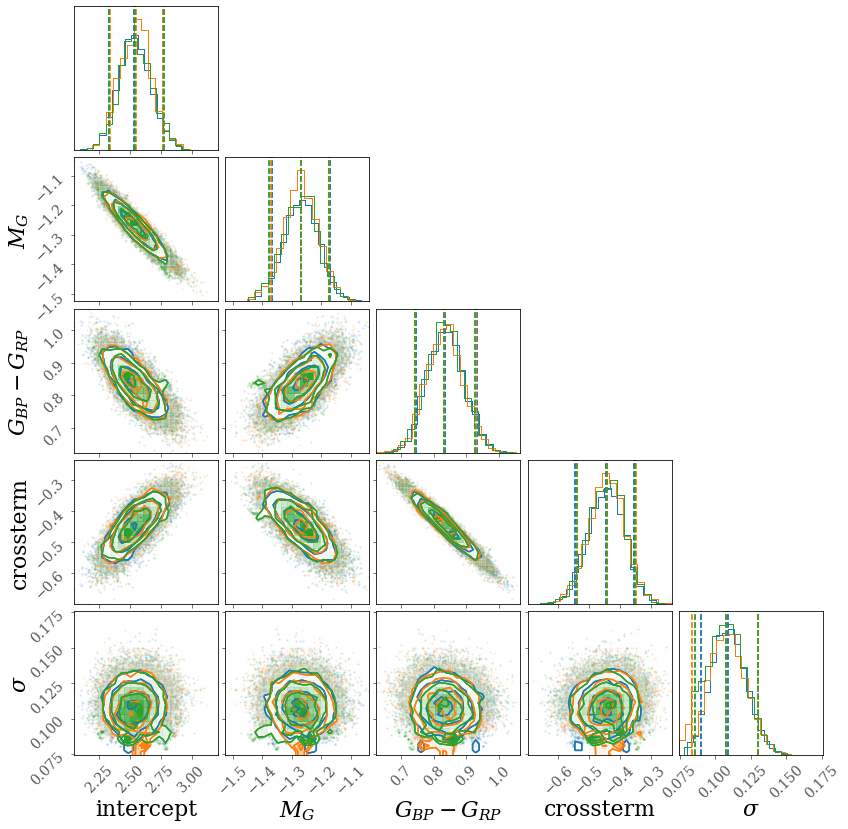

In [ ]:
fig = corner.corner(np.vstack((edr3_trace.get_values('intercept', chains=0),
                               edr3_trace.get_values('beta_absg', chains=0), 
                               edr3_trace.get_values('beta_bprp', chains=0), 
                               edr3_trace.get_values('beta_xterm', chains=0),
                              #  edr3_trace.get_values('beta_absg_2', chains=0), 
                              #  edr3_trace.get_values('beta_bprp_2', chains=0),
                               edr3_trace.get_values('sigma', chains=0))).T, 
                    labels = ['intercept', '$M_G$', 
                              '$G_{BP}-G_{RP}$', 'crossterm',
                              # '$M_G^2$', 
                              # '$(G_{BP}-G_{RP})^2$',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, fig=fig,
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((edr3_trace.get_values('intercept', chains=1),
                         edr3_trace.get_values('beta_absg', chains=1), 
                         edr3_trace.get_values('beta_bprp', chains=1), 
                         edr3_trace.get_values('beta_xterm', chains=1),
                        #  edr3_trace.get_values('beta_absg_2', chains=1), 
                        #  edr3_trace.get_values('beta_bprp_2', chains=1),
                         edr3_trace.get_values('sigma', chains=1))).T,
              fig=fig, color='#ff7f0e', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((edr3_trace.get_values('intercept', chains=2),
                         edr3_trace.get_values('beta_absg', chains=2), 
                         edr3_trace.get_values('beta_bprp', chains=2), 
                         edr3_trace.get_values('beta_xterm', chains=2),
                        #  edr3_trace.get_values('beta_absg_2', chains=2), 
                        #  edr3_trace.get_values('beta_bprp_2', chains=2),
                         edr3_trace.get_values('sigma', chains=2))).T,
              fig=fig, color='#2ca02c', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

We take the median and 90% confidence interval as the measurement and uncertainty for each $\beta$ parameter. Since all parameters look reasonably converged, we'll treat the uncertainty as symmetric.

In [ ]:
with edr3_model:
    display(az.summary(edr3_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                                     'beta_xterm',
                                                                     'sigma'], :])

mean     sd  hdi_16%  hdi_84%  mcse_mean  mcse_sd  ess_bulk  \
intercept   2.545  0.132    2.409    2.669      0.003    0.002  2621.641   
beta_absg  -1.271  0.060   -1.325   -1.208      0.001    0.001  2150.923   
beta_bprp   0.834  0.057    0.776    0.889      0.001    0.001  1996.430   
beta_xterm -0.445  0.058   -0.500   -0.386      0.001    0.001  2227.512   
sigma       0.108  0.013    0.094    0.120      0.001    0.000   337.731   

            ess_tail  r_hat  
intercept   4684.141  1.001  
beta_absg   1256.677  1.002  
beta_bprp   4667.597  1.002  
beta_xterm  4053.678  1.001  
sigma        124.181  1.008

In [ ]:
df = az.summary(edr3_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                              'beta_xterm',
                                                              'sigma'], :]

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [ ]:
print(df['hdi_84%']-df['mean'])
print(df['mean']-df['hdi_16%'])

intercept     0.124
beta_absg     0.063
beta_bprp     0.055
beta_xterm    0.059
sigma         0.012
dtype: float64
intercept     0.136
beta_absg     0.054
beta_bprp     0.058
beta_xterm    0.055
sigma         0.014
dtype: float64


In [ ]:
beta0 = np.median(edr3_trace['intercept'])
betaX = np.median(edr3_trace['beta_bprp'])
betaY = np.median(edr3_trace['beta_absg'])
betaXY = np.median(edr3_trace['beta_xterm'])
sigma_hat = np.median(edr3_trace['sigma'])

beta0_sig = np.percentile(edr3_trace['intercept'], 95) - beta0
betaX_sig = np.percentile(edr3_trace['beta_bprp'], 95) - betaX
betaY_sig = np.percentile(edr3_trace['beta_absg'], 95) - betaY
betaXY_sig = np.percentile(edr3_trace['beta_xterm'], 95) - betaXY

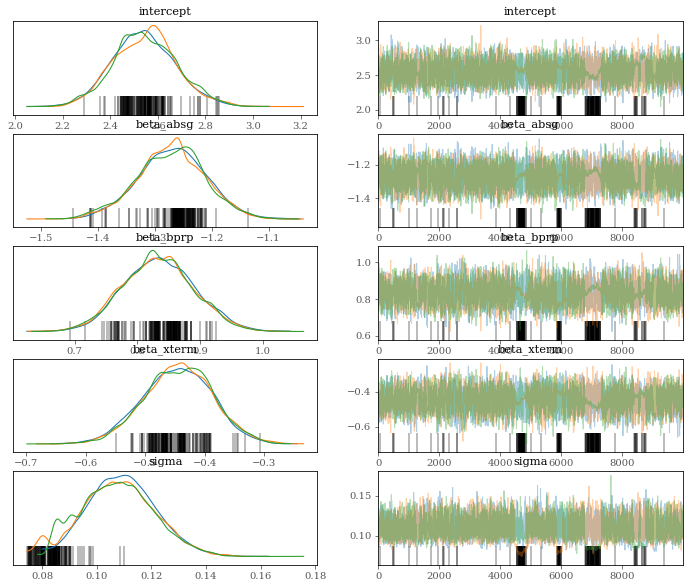

In [ ]:
with edr3_model:
    az.plot_trace(edr3_trace, 
                  var_names=['intercept', 'beta_absg', 
                             'beta_bprp', 'beta_xterm',
                             'sigma'], 
                  combined=False, compact=False)

These plots all show a convincingly converged fit, pointing to $P_{orb}$ being dependent on luminosity in the $G$ band and $G_{BP}-G_{RP}$ colors.

## Visualizing the Linear Fit on the *Gaia* CMD

We use a background sample of nearby *Gaia* stars to illustrate the location of the Main Sequence and White Dwarf Sequence on the cmd.

In [ ]:
hey_neighbor_df = pd.read_csv('/content/drive/MyDrive/cv_paper/data/gcns.csv')

In [ ]:
nearby_distance = hey_neighbor_df['dist50_kpc_'] * 1000
nearby_g = hey_neighbor_df['phot_g_mean_mag']
nearby_bp_rp = hey_neighbor_df['bp_rp']
nearby_absg = nearby_g - 5*np.log10(nearby_distance) + 5

Our fit interpolates across the optical color bounds and $M_G$ bounds of the RK16 Catalog. We simulate the span of the fit across the bounds.

In [ ]:
res = 50

bp_rp_sim = np.linspace(-0.5, 2.75, res)
abs_g_sim = np.linspace(14, 1.5, res)

Text(0, 0.5, '$M_G$')

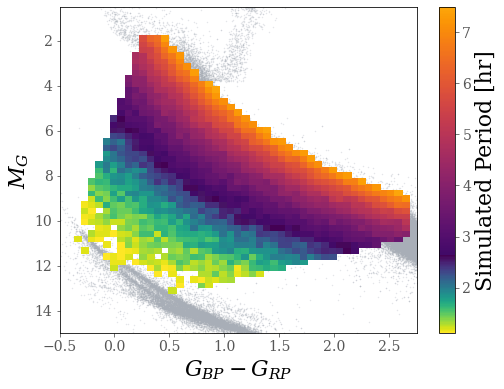

In [ ]:
period_grid = np.ones((res, res))

#this for-loop goes through jj first and then ii
for ii in range(res):
    for jj in range(res):
        #jj is x value (row index), ii is y value (column index)
        var = np.random.normal(0, sigma_hat, 1)
        period_grid[ii, jj] = p_orb_med * beta0 * np.exp(betaX*((bp_rp_sim[jj])/bp_rp_med) +
                                                         betaY*((abs_g_sim[ii])/abs_g_med) +
                                                         betaXY*((bp_rp_sim[jj])/bp_rp_med)*((abs_g_sim[ii])/abs_g_med) #+
                                                        #  betaY2*((abs_g_sim[ii]/abs_g_med)**2) +
                                                        #  betaX2*((bp_rp_sim[jj]/bp_rp_med)**2)
                                                        ) + var
                                             

plt.figure(figsize=(8,6))
color = bp_rp_sim
mag = abs_g_sim
X,Y = np.meshgrid(color,mag)

Z = period_grid

Z = np.ma.masked_where((Z > 7.5), Z)
Z = np.ma.masked_where((Z < 1.1), Z)
Z = np.ma.masked_where((Y < 2), Z)
Z = np.ma.masked_where((Y > 13.3), Z)
Z = np.ma.masked_where((X < -0.4), Z)
Z = np.ma.masked_where((X > 2.68), Z)
Z = np.ma.masked_where((Y < -14.29*X + 5), Z) 
Z = np.ma.masked_where((Y > -1.17*X + 14), Z)


cmap = plt.cm.viridis_r
cmap.set_bad(color='black', alpha=0.0)

plt.scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7', alpha=0.3, s=1, zorder=-1)

cb = plt.pcolormesh(X,Y,Z, cmap=cv_map)
plt.colorbar(cb, label='Simulated Period [hr]')

plt.xlim(-0.5, 2.75)
plt.ylim(15, 0.5)
plt.xlabel('$G_{BP} - G_{RP}$', fontsize=22)
plt.ylabel('$M_G$', fontsize=22)

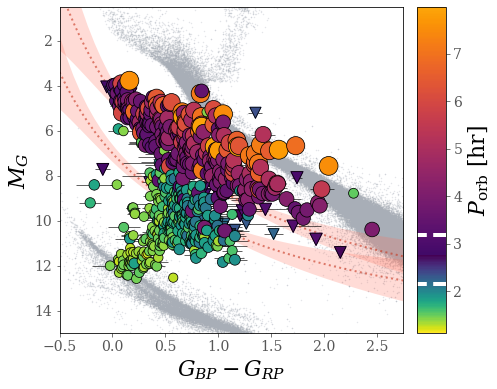

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7', 
            alpha=0.3, s=1, zorder=-1, rasterized=True)

plt.errorbar(bp_rp, abs_g, 
             yerr=[abs_g_lowlim, abs_g_uplim], 
             xerr=bp_rp_err, fmt='none',
             color='k', 
             linewidth=0.6)

gap_mask = (p_orb > 2.15) & (p_orb < 3.18)

plt.scatter(bp_rp.loc[gap_mask], abs_g.loc[gap_mask], 
            c=p_orb.loc[gap_mask], cmap=gap_map, 
            marker='v', alpha=1,
            s=(p_orb.loc[gap_mask]**(1/1.25))*60, 
            zorder=6)

plt.scatter(bp_rp.loc[gap_mask], abs_g.loc[gap_mask], 
            c='none', edgecolor='k', 
            linewidth=0.75, marker='v',
            s=(p_orb.loc[gap_mask]**(1/1.25))*60, 
            zorder=6)

cb = plt.scatter(bp_rp.loc[~gap_mask], abs_g.loc[~gap_mask], 
                 c=p_orb.loc[~gap_mask], cmap=cv_map, 
                 edgecolor='k', linewidth=0.75, 
                 s=(p_orb.loc[~gap_mask]**(1/1.25))*70, 
                 zorder=7)

#Period Sequences
color = '#ff725c'

for ii in [2.15,3.18]:
    
    absg_fits = abs_g_med * ((np.log(ii/(p_orb_med*edr3_trace['intercept'][:, None])) \
                              - edr3_trace['beta_bprp'][:, None]*bp_rp_sim/bp_rp_med)/(edr3_trace['beta_absg'][:, None] \
                              + edr3_trace['beta_xterm'][:, None]*bp_rp_sim/bp_rp_med)
                            )
        
    absg_mu = absg_fits.mean(0)
    absg_sig = absg_fits.std(0)
        
    plt.plot(bp_rp_sim, absg_mu, c='#c7351e', linestyle=':', linewidth=2,
             alpha=0.6)
    
    plt.fill_between(bp_rp_sim, absg_mu - 3*absg_sig, absg_mu + 3*absg_sig, 
                     facecolor=color, alpha=0.25)
    
labelLines(plt.gca().get_lines(), 
           xvals=[2.3, 2.2], fontweight='bold', color='#c7351e',
           size=16, align=False, zorder=0)

plt.xlim(-0.5, 2.75)
plt.ylim(15, 0.5)
plt.xlabel('$G_{BP} - G_{RP}$', fontsize=22)
plt.ylabel('$M_G$', fontsize=22)

cbax = plt.colorbar(cb, label=r'$P_{\rm orb}$ [hr]',
                    fraction=0.2, aspect=11, pad=0.03,
                    format=mpl.ticker.ScalarFormatter())
cbax.ax.hlines([2.15,3.18], 0, 10, colors = 'white', linewidth = 4, linestyles = '--')

# plt.subplots_adjust(wspace=0.01)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/rk_camd_lines.pdf', bbox_inches = 'tight', pad_inches = 0.15)

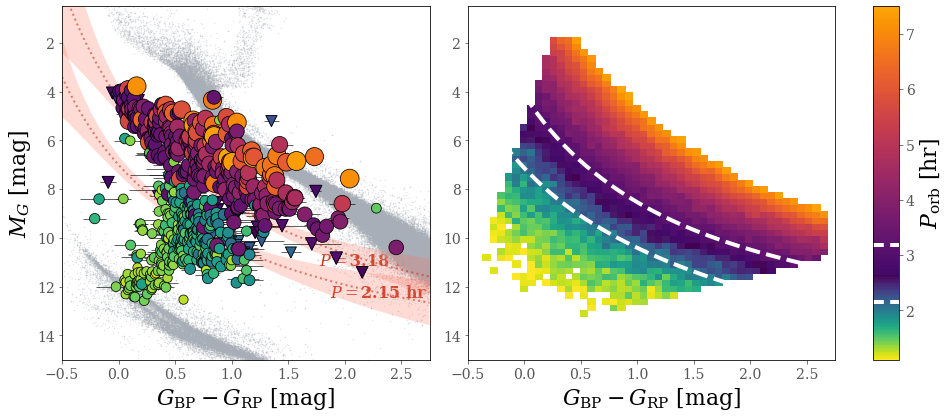

In [ ]:
fig, (ax, ax2, cax) = plt.subplots(ncols=3,figsize=(15, 6.5), 
                                   gridspec_kw={"width_ratios":[1, 1, 0.07]})

#Left Subplot

fig.subplots_adjust(wspace=0.15)

ax.scatter(nearby_bp_rp, nearby_absg, marker='.', 
           c='#a8aeb7', alpha=0.3, s=1, zorder=1, rasterized=True)

ax.errorbar(bp_rp, abs_g, 
            yerr=[abs_g_lowlim, abs_g_uplim], 
            xerr=bp_rp_err, fmt='none',
            color='k', 
            linewidth=0.6)

gap_mask = (p_orb > 2.15) & (p_orb < 3.18)

ax.scatter(bp_rp.loc[gap_mask], abs_g.loc[gap_mask], 
           c=p_orb.loc[gap_mask], cmap=gap_map, 
           marker='v', alpha=1,
           s=(p_orb.loc[gap_mask]**(1/1.25))*60, 
           zorder=6)

ax.scatter(bp_rp.loc[gap_mask], abs_g.loc[gap_mask], 
           c='none', edgecolor='k', 
           linewidth=0.75, marker='v',
           s=(p_orb.loc[gap_mask]**(1/1.25))*60, 
           zorder=6)

ax.scatter(bp_rp.loc[~gap_mask], abs_g.loc[~gap_mask], 
           c=p_orb.loc[~gap_mask], cmap=cv_map, 
           edgecolor='k', linewidth=0.75, 
           s=(p_orb.loc[~gap_mask]**(1/1.25))*70, 
           zorder=7)

#Period Sequences
color = '#ff725c'

for ii in [2.15,3.18]:
    
    absg_fits = abs_g_med * ((np.log(ii/(p_orb_med*edr3_trace['intercept'][:, None])) \
                              - edr3_trace['beta_bprp'][:, None]*bp_rp_sim/bp_rp_med)/(edr3_trace['beta_absg'][:, None] \
                              + edr3_trace['beta_xterm'][:, None]*bp_rp_sim/bp_rp_med)
                            )
        
    absg_mu = absg_fits.mean(0)
    absg_sig = absg_fits.std(0)
        
    ax.plot(bp_rp_sim, absg_mu, c='#c7351e', linestyle=':', linewidth=2,
            label='$P=${} hr'.format(np.round(ii, 2)), alpha=0.6)
    
    ax.fill_between(bp_rp_sim, absg_mu - 3*absg_sig, absg_mu + 3*absg_sig, 
                    facecolor=color, alpha=0.25)
    
labelLines(ax.get_lines(), 
           xvals=[2.3, 2.2], fontweight='bold', color='#c7351e',
           size=16, align=False, zorder=0)


ax.set_xlim(-0.5, 2.75)
ax.set_ylim(15, 0.5)
ax.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]')
ax.set_ylabel('$M_G$ [mag]')

#------------------------------------------------------------------

#Right Subplot

cb = ax2.pcolormesh(X,Y,Z, cmap=cv_map, zorder=0)
color = '#ffffff'

for ii in [2.15,3.18]:
    absg_fits = abs_g_med * ((np.log(ii/(p_orb_med*edr3_trace['intercept'][:, None])) - edr3_trace['beta_bprp'][:, None]*bp_rp_sim/bp_rp_med)/
                             (edr3_trace['beta_absg'][:, None] + edr3_trace['beta_xterm'][:, None]*bp_rp_sim/bp_rp_med)
                            )
    
    absg_mu = absg_fits.mean(0)
    absg_sig = absg_fits.std(0)
        
    if ii == 2.15:

        ax2.plot(bp_rp_sim, absg_mu + absg_sig, c=color, linestyle='--', linewidth=4, 
                 label='$P=${} hr'.format(np.round(ii, 2)))
        
    else:
        ax2.plot(bp_rp_sim, absg_mu - absg_sig, c=color, linestyle='--', linewidth=4, 
                 label='$P=${} hr'.format(np.round(ii, 2)))


ax2.set_xlim(-0.5, 2.75)
ax2.set_ylim(15, 0.5)
ax2.set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]')

cbax = fig.colorbar(cb, label=r'$P_{\rm orb}$ [hr]', cax=cax, format=mpl.ticker.ScalarFormatter())
cbax.ax.hlines([2.15,3.18], 0, 10, colors = 'white', linewidth = 4, linestyles = '--')

plt.savefig('/content/drive/MyDrive/cv_paper/figures/rk_fit.pdf', bbox_inches = 'tight', pad_inches = 0.15)

In [ ]:
p_orb_hat =  p_orb_med * beta0 * np.exp(betaX*(bp_rp/bp_rp_med) +
                                        betaY*(abs_g/abs_g_med) +
                                        betaXY*(bp_rp/bp_rp_med)*(abs_g/abs_g_med))

Limit the predicted values to those within the bounds of the training set.

In [ ]:
p_orb_for_est = p_orb.loc[(p_orb_hat < 8) & (p_orb_hat > 1.1)]
p_orb_hat = p_orb_hat.loc[(p_orb_hat < 8) & (p_orb_hat > 1.1)]

We can visualize the distributions of $\hat{P}_{\rm orb}$ for a given measured period in a violin plot, by binning data into observed $P_{\rm orb}$ bins.

In [ ]:
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


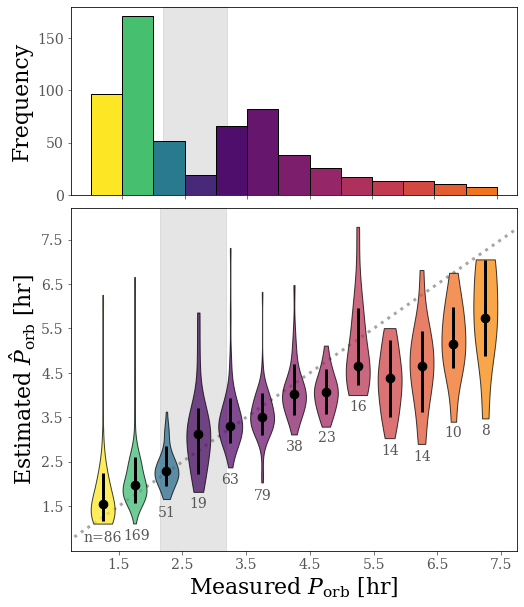

In [ ]:
fig, (ax, ax2) = plt.subplots(nrows=2,figsize=(8, 10), 
                                   gridspec_kw={"height_ratios":[0.55, 1]})

#Upper Subplot

n, bins, patches = ax.hist(vsx_df['period']*24, bins=np.arange(1.0, 8.0, 0.5),
                            fc='Tomato', ec='k')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cv_map(i/len(np.arange(1.0, 8.0, 0.5))))

ax.set_ylabel('Frequency', fontsize=22)
ax.axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

ax.set_xticks(np.arange(1.5, 8.5, 1))
ax.set_xticklabels(np.repeat('', 7))


#------------------------------------------------------------------

#Lower Subplot


porb_1 = p_orb_hat.loc[(p_orb_for_est >= 1) & (p_orb_for_est < 1.5)]
porb_15 = p_orb_hat.loc[(p_orb_for_est >= 1.5) & (p_orb_for_est < 2)]
porb_2 = p_orb_hat.loc[(p_orb_for_est >= 2) & (p_orb_for_est < 2.5)]
porb_25 = p_orb_hat.loc[(p_orb_for_est >= 2.5) & (p_orb_for_est < 3)]
porb_3 = p_orb_hat.loc[(p_orb_for_est >= 3) & (p_orb_for_est < 3.5)]
porb_35 = p_orb_hat.loc[(p_orb_for_est >= 3.5) & (p_orb_for_est < 4)]
porb_4 = p_orb_hat.loc[(p_orb_for_est >= 4) & (p_orb < 4.5)]
porb_45 = p_orb_hat.loc[(p_orb >= 4.5) & (p_orb_for_est < 5)]
porb_5 = p_orb_hat.loc[(p_orb_for_est >= 5) & (p_orb_for_est < 5.5)]
porb_55 = p_orb_hat.loc[(p_orb_for_est >= 5.5) & (p_orb_for_est < 6)]
porb_6 = p_orb_hat.loc[(p_orb_for_est >= 6) & (p_orb_for_est < 6.5)]
porb_65 = p_orb_hat.loc[(p_orb_for_est >= 6.5) & (p_orb_for_est < 7)]
porb_7 = p_orb_hat.loc[(p_orb_for_est >= 7) & (p_orb_for_est < 7.5)]

## combine these different collections into a list
violin_bins = np.array([porb_1.values, porb_15.values, porb_2.values, porb_25.values,
                        porb_3.values, porb_35.values, porb_4.values, porb_45.values,
                        porb_5.values, porb_55.values, porb_6.values, porb_65.values,
                        porb_7.values
                       ])

bp = ax2.violinplot(violin_bins, widths=0.75,
                    showmeans=False, showmedians=False, 
                    showextrema=False)

colors = [cv_map((1.*i/len(violin_bins))) for i in range(len(violin_bins))]
iter_colors = itertools.cycle(colors)

for pc in bp['bodies']:
    color = list(next(iter_colors))
    color[3]=0.8
    pc.set_facecolor(tuple(color))
    pc.set_edgecolor('k')
    pc.set_alpha(0.75)
    
percentiles=[]   
for ii in range(len(violin_bins)):
    percentiles.append(np.percentile(violin_bins[ii], [12.5, 50, 87.5]))

quartile1, medians, quartile3 = np.array(percentiles)[:,0],np.array(percentiles)[:,1], np.array(percentiles)[:,2]
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(violin_bins, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='k', s=75, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=3)

#these lines define the transformation between xcoord axis and number line
ax2.set_xticks(np.arange(1.5, 15.5, 2))
ax2.set_xticklabels(np.arange(1.5, 8.5, 1))


#transform the gap limits into the x coordinate system
ax2.axvspan(2.80, 4.86, alpha=0.2, color='Grey', zorder=0) 
ax2.plot([-0.5,15.5], [0.5,8.5], c='k', 
         ls=':', lw=3, alpha=0.35,
         zorder=-1) #recast to accomodate x coordinate system

ax2.set_yticks(np.arange(1.5, 8.5, 1))

ax2.set_xlim(0, 14)
ax2.set_ylim(0.5, 8.2)

#annotations
ax2.annotate('n='+str(len(porb_1)), (0.4, 0.7), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_15)), (1.65, 0.75), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_2)), (2.73, 1.25), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_25)), (3.73, 1.47), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_3)), (4.73, 2.), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_35)), (5.73, 1.65), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_4)), (6.74, 2.75), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_45)), (7.74, 2.95), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_5)), (8.74, 3.65), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_55)), (9.74, 2.65), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_6)), (10.74, 2.52), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_65)), (11.73, 3.05), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_7)), (12.87, 3.1), fontsize=14, c='#575757')

ax2.set_xlabel(r'Measured $P_{\rm orb}$ [hr]')
ax2.set_ylabel(r'Estimated $\hat{P}_{\rm orb}$ [hr]')

plt.subplots_adjust(hspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/rk_gof.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## The $P_{orb}$-CMD Relationship in DR2

We'll investigate how much the relationship has changed as a function of sample size, *i.e.* of *Gaia* data release number. This will depend on how much the CMD position of each CV has changed from survey to survey as dependent on time-averaged photometry and **not** astrometry, since we do expect each CV to vary photometrically over time but not in distance. Therefore, we'll use the more precise DR3 positions.

In [ ]:
dr2_vsx_df = vsx_df.loc[np.isfinite(vsx_df['dr2_bp_rp']) & no_cn_mask]

In [ ]:
len(dr2_vsx_df)

610

In [ ]:
dr2_p_orb = dr2_vsx_df['period']*24
dr2_abs_g = dr2_vsx_df['dr2_phot_g_mean_mag'] - 5*np.log10(dr2_vsx_df['r_med_geo']) + 5
dr2_bp_rp = dr2_vsx_df['dr2_bp_rp']

dr2_p_orb_med = np.median(dr2_p_orb)
dr2_abs_g_med = np.median(dr2_abs_g)
dr2_bp_rp_med = np.median(dr2_bp_rp)

dr2_p_orb_norm = dr2_p_orb/p_orb_med
dr2_abs_g_norm = dr2_abs_g/dr2_abs_g_med
dr2_bp_rp_norm = dr2_bp_rp/dr2_bp_rp_med

In [ ]:
dr2_g_err = 1.086 * dr2_vsx_df['dr2_phot_g_mean_flux_error']/dr2_vsx_df['dr2_phot_g_mean_flux']
dr2_bp_err = 1.086 * dr2_vsx_df['dr2_phot_bp_mean_flux_error']/dr2_vsx_df['dr2_phot_bp_mean_flux']
dr2_rp_err = 1.086 * dr2_vsx_df['dr2_phot_rp_mean_flux_error']/dr2_vsx_df['dr2_phot_rp_mean_flux']

dr2_bp_rp_err = np.sqrt(dr2_bp_err**2 + dr2_rp_err**2)

dr2_abs_g_uplim = 1.086 * np.sqrt((2*(dr2_vsx_df['r_med_geo']-dr2_vsx_df['r_lo_geo'])/dr2_vsx_df['r_med_geo'])**2 + dr2_g_err**2)
dr2_abs_g_lowlim = 1.086 * np.sqrt((2*(dr2_vsx_df['r_hi_geo']-dr2_vsx_df['r_med_geo'])/dr2_vsx_df['r_med_geo'])**2 + dr2_g_err**2)

dr2_abs_g_geom_err = np.sqrt((dr2_abs_g_uplim)**2 + 
                             (dr2_abs_g_lowlim)**2)

As above, we calculate MLE estimates of the prior.

In [ ]:
soln = minimize(nll, initial, args=(dr2_bp_rp, dr2_bp_rp_err, 
                                    dr2_abs_g, dr2_abs_g_geom_err, 
                                    dr2_p_orb), method='BFGS')
dr2_beta_0_ml, dr2_beta_x_ml, dr2_beta_y_ml, dr2_beta_xy_ml = soln.x

In [ ]:
np.isfinite(dr2_bp_rp_err).all()

True

In [ ]:
with pm.Model() as dr2_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", sd=1) 
    b0 = pm.Normal("intercept", dr2_beta_0_ml, sigma=10)
    bX = pm.Normal("beta_bprp", dr2_beta_x_ml, sigma=10)
    bY = pm.Normal("beta_absg", dr2_beta_y_ml, sigma=10)
    bXY = pm.Normal("beta_xterm", dr2_beta_xy_ml, sigma=10)
    
    # Set X_i as RVs to incorporate their uncertainty
    obs_abs_g = pm.Normal('obs_abs_g', mu=dr2_abs_g_norm, sd=dr2_abs_g_geom_err, 
                          shape=len(dr2_abs_g_norm))
    obs_bp_rp = pm.Normal('obs_bp_rp', mu=dr2_bp_rp_norm, sd=dr2_bp_rp_err, 
                          shape=len(dr2_bp_rp_norm))

    # Define linear model
    y_est = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g 
                        + bXY*(obs_bp_rp*obs_abs_g))

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=dr2_p_orb_norm
    )
    
    dr2_trace = pm.sample(10000, cores=3, target_accept=0.8,
                          return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 230 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
with dr2_model:
    display(az.summary(dr2_trace, round_to=2).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                       'beta_xterm', 'sigma'], :])

mean    sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept   2.71  0.14    2.44     2.97  ...      0.0   4319.86   8429.52    1.0
beta_absg  -1.31  0.06   -1.43    -1.20  ...      0.0   4522.50   8581.35    1.0
beta_bprp   0.76  0.06    0.65     0.87  ...      0.0   2843.99   2962.49    1.0
beta_xterm -0.39  0.06   -0.50    -0.28  ...      0.0   3096.70   4448.59    1.0
sigma       0.11  0.01    0.09     0.13  ...      0.0   1967.28   1669.04    1.0

[5 rows x 9 columns]

For comparison, these are the numbers from EDR3:

In [ ]:
with edr3_model:
    display(az.summary(edr3_trace, round_to=2).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                       'beta_xterm', 'sigma'], :])

mean    sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept   2.55  0.13    2.31     2.79  ...      0.0   1350.19   3552.43   1.00
beta_absg  -1.27  0.06   -1.38    -1.16  ...      0.0   1579.70   4148.49   1.00
beta_bprp   0.83  0.06    0.73     0.94  ...      0.0   1503.60   2271.76   1.00
beta_xterm -0.44  0.06   -0.56    -0.34  ...      0.0   1722.05   3036.58   1.00
sigma       0.11  0.01    0.09     0.13  ...      0.0    374.77    180.12   1.01

[5 rows x 9 columns]

These coefficients are remarkably similar, and equivalent within their confidence intervals.

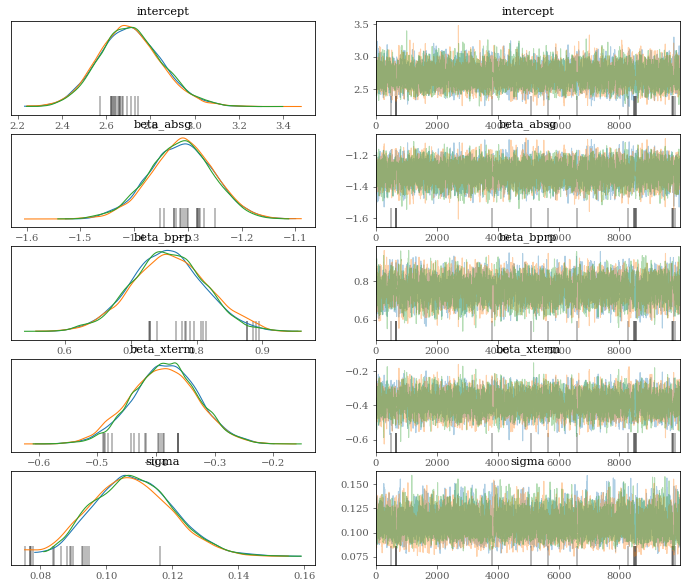

In [ ]:
with dr2_model:
    az.plot_trace(dr2_trace, 
                  var_names=['intercept', 'beta_absg', 
                             'beta_bprp', 'beta_xterm', 
                             'sigma'], 
                  combined=False, compact=False)

If we compare the corner plots of the coefficients between DR2 and EDR3, we get the following:

In [ ]:
del(fig2)

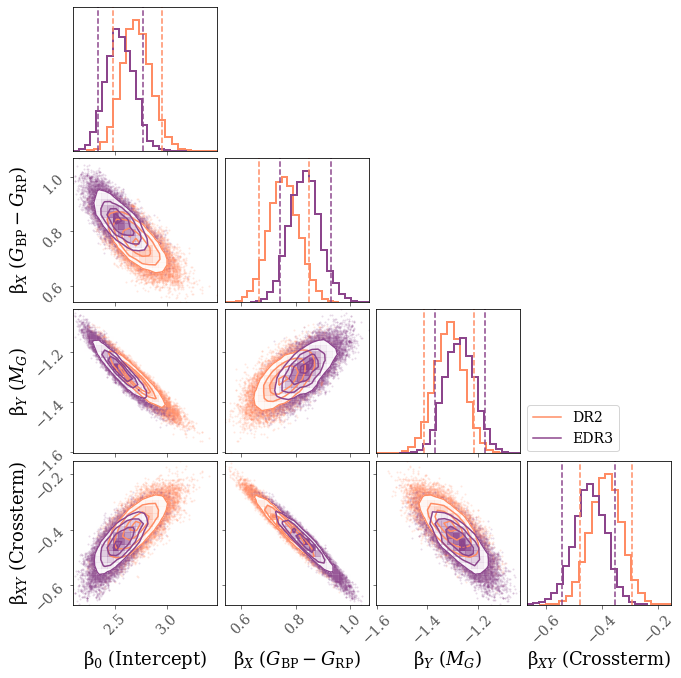

In [ ]:
dr2_line = mlines.Line2D([], [], color='#FF8C64', label='DR2')
edr3_line = mlines.Line2D([], [], color='#8c458c', label='EDR3')

fig2 = corner.corner(np.vstack((dr2_trace['intercept'],
                                dr2_trace['beta_bprp'],
                                dr2_trace['beta_absg'],  
                                dr2_trace['beta_xterm'])).T, 
                     labels = ['β$_0$ (Intercept)', r'β$_X$ ($G_{\rm BP}-G_{\rm RP}$)',
                               'β$_Y$ ($M_G$)', 'β$_{XY}$ (Crossterm)'], 
                     color='#FF8C64', hist_kwargs=dict(linewidth=2),
                     data_kwargs=dict(alpha=0.2), #fig=fig2,
                     label_kwargs={"fontsize": 18, "labelpad": 5}, 
                     max_n_ticks=3, plot_contours=True,
                     quantiles=[0.05,0.95], zorder=0)

corner.corner(np.vstack((edr3_trace['intercept'],
                         edr3_trace['beta_bprp'],
                         edr3_trace['beta_absg'], 
                         edr3_trace['beta_xterm'])).T,
              fig=fig2, color='#8c458c', #'#8F338C',
              data_kwargs=dict(alpha=0.2),
              hist_kwargs=dict(linewidth=2),
              max_n_ticks=3, plot_contours=True,
              quantiles=[0.05,0.95], zorder=1)

plt.legend(handles=[dr2_line,edr3_line], 
           bbox_to_anchor=(0., 1.015, 0.685, .0), 
           loc=4, prop={'size': 14})

plt.savefig('/content/drive/MyDrive/cv_paper/figures/release_posteriors.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## CMD Position as a Function of *Gaia* Release Number

Given that the *Gaia* color span of RK16 is ~2.5 in $G_{BP}-G_{RP}$ space, we consider something having moved significantly on the CMD when its color has changed by more than 0.25, or 10\% of the CV color space, between releases.

In [ ]:
vsx_movers = vsx_df.loc[(np.abs(vsx_df['dr2_bp_rp'] - vsx_df['bp_rp']) > 0.25) | 
                      (np.abs(abs_g - (vsx_df['dr2_phot_g_mean_mag'] - 
                                       5*np.log10(vsx_df['r_med_geo']) + 5)) > 1.1)].copy()
vsx_movers['abs_g'] = vsx_movers['phot_g_mean_mag'] - 5*np.log10(vsx_movers['r_med_geo']) + 5
vsx_movers['dr2_abs_g'] = vsx_movers['dr2_phot_g_mean_mag'] - 5*np.log10(vsx_movers['r_med_geo']) + 5

In [ ]:
print(str(np.round(len(vsx_movers)/len(vsx_df)*100, 2))+'% of the VSX CV-Gaia Sample moved more than 10% in color space and/or absmag space the CMD.')
print(str(len(vsx_movers))+' objects')

3.21% of the VSX CV-Gaia Sample moved more than 10% in color space and/or absmag space the CMD.
20 objects


We check to see how much sampling count makes a difference in this motion -- it turns out not by much.

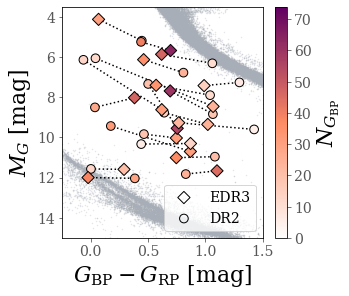

In [ ]:
fig = plt.figure(figsize=(4.5,4.25))

plt.scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7',
            label='', rasterized=True,
            alpha=0.3, s=1, zorder=-1)


for ii in range(int(len(vsx_movers))):
    plt.plot([vsx_movers['bp_rp'].iloc[ii], vsx_movers['dr2_bp_rp'].iloc[ii]], 
             [vsx_movers['abs_g'].iloc[ii], vsx_movers['dr2_abs_g'].iloc[ii]], 
             'k.:', label='',zorder=0)
    
cb = plt.scatter(vsx_movers['bp_rp'], vsx_movers['abs_g'],
                 marker='D', c=vsx_movers['phot_bp_n_obs'], 
                 cmap=obs_map, vmin=0, vmax=74,
                 label='EDR3',edgecolor='k', s=75, zorder=3)

plt.scatter(vsx_movers['dr2_bp_rp'], vsx_movers['dr2_abs_g'],
            marker='o', c=vsx_movers['dr2_phot_bp_n_obs'], 
            cmap=obs_map, vmin=0, vmax=74,
            label='DR2',edgecolor='k', s=75, zorder=2)

cbar = plt.colorbar(cb, label=r'$N_{G_{\rm BP}}$')

leg = plt.legend(loc='lower right', prop={'size':14})
leg.legendHandles[0].set_facecolor('None')
leg.legendHandles[1].set_facecolor('None')

plt.xlim(-0.25, 1.5)
plt.ylim(15, 3.5)

plt.xticks(np.arange(0, 1.75, 0.5))

plt.xlabel(r'$G_{\rm BP}-G_{\rm RP}$ [mag]')
plt.ylabel('$M_G$ [mag]')

plt.savefig('/content/drive/MyDrive/cv_paper/figures/movers.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## The Semi-Empirical Donor Sequence in EDR3

Bring in the semi-empirical Donor Sequence from *Knigge et al. 2011*.

In [ ]:
donor_seq_table = Table.read('/content/drive/MyDrive/cv_paper/data/knigge11_donorsequence.txt', format='ascii.cds')

In [ ]:
donor_seq = donor_seq_table.to_pandas()

Convert the bandpasses from Knigge11 to *Gaia* G, using the relationship provided in the [EDR3 Documentation](https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html).

$G - V = -0.15 - 0.5 \cdot (V-R) - 0.32 \cdot (V-R)**2$

In [ ]:
# DR2 Transformation
# donor_seq_g = -0.0028 + 0.7632*(donor_seq['VMag'] - 
#                                 donor_seq['RMag']) - 0.6894*(donor_seq['VMag'] - 
#                                                              donor_seq['RMag'])**2 + 0.0974*(donor_seq['VMag'] - 
#                                                                                              donor_seq['RMag'])**3 + donor_seq['RMag']

donor_seq_g = -0.15 + 0.5*(donor_seq['VMag'] - 
                           donor_seq['RMag']) - 0.32*(donor_seq['VMag'] - 
                                                      donor_seq['RMag'])**2 + donor_seq['VMag']

## Look at the Position of CV Types on the CMD

I'm going to now make a modified list that simplifies these different types following what's in the Inight paper. Also, I reimport all my CAMD variables without the CN mask for now.

In [ ]:
p_orb = (vsx_df['period']*24)
abs_g = (vsx_df['phot_g_mean_mag'] - 5*np.log10(vsx_df['r_med_geo']) + 5)
bp_rp = (vsx_df['bp_rp'])

p_orb_med = np.median(p_orb)
abs_g_med = np.median(abs_g)
bp_rp_med = np.median(bp_rp)

p_orb_norm = p_orb/p_orb_med
abs_g_norm = abs_g/abs_g_med
bp_rp_norm = bp_rp/bp_rp_med

g_err = (1.086 * vsx_df['phot_g_mean_flux_error']/vsx_df['phot_g_mean_flux'])
bp_err = (1.086 * vsx_df['phot_bp_mean_flux_error']/vsx_df['phot_bp_mean_flux'])
rp_err = (1.086 * vsx_df['phot_rp_mean_flux_error']/vsx_df['phot_rp_mean_flux'])

bp_rp_err = np.sqrt(bp_err**2 + rp_err**2)

abs_g_uplim = 1.086 * np.sqrt((2*(vsx_df['r_med_geo']-
                                  vsx_df['r_lo_geo'])/vsx_df['r_med_geo'])**2 
                              + g_err**2)
abs_g_lowlim = 1.086 * np.sqrt((2*(vsx_df['r_hi_geo']
                                   -vsx_df['r_med_geo'])/
                                vsx_df['r_med_geo'])**2 
                               + g_err**2)

abs_g_geom_err = np.sqrt((abs_g_uplim)**2 + 
                         (abs_g_lowlim)**2)

In [ ]:
pd.unique(vsx_df['gen_type'])

array(['UG', 'AM', 'NL', 'DQ', 'CN', 0.0], dtype=object)

All the places where `gen_type` is zero are just general CVs.

In [ ]:
ug_mask = (vsx_df['gen_type'] == 'UG') 
mag_mask = ((vsx_df['gen_type'] == 'AM') | (vsx_df['gen_type'] == 'DQ'))
nl_mask = (vsx_df['gen_type'] == 'NL')
nov_mask = (vsx_df['gen_type'] == 'CN')

am_mask = ((vsx_df['gen_type'] == 'AM') & mag_mask)
dq_mask = ((vsx_df['gen_type'] == 'DQ') & mag_mask)

gencv_mask = (vsx_df['gen_type'] == 0.0)

disk_mask = (ug_mask | nl_mask | nov_mask | dq_mask)

gap_mask = (p_orb > 2.15) & (p_orb < 3.18)

dist_mask = vsx_df['r_med_geo'] < 300

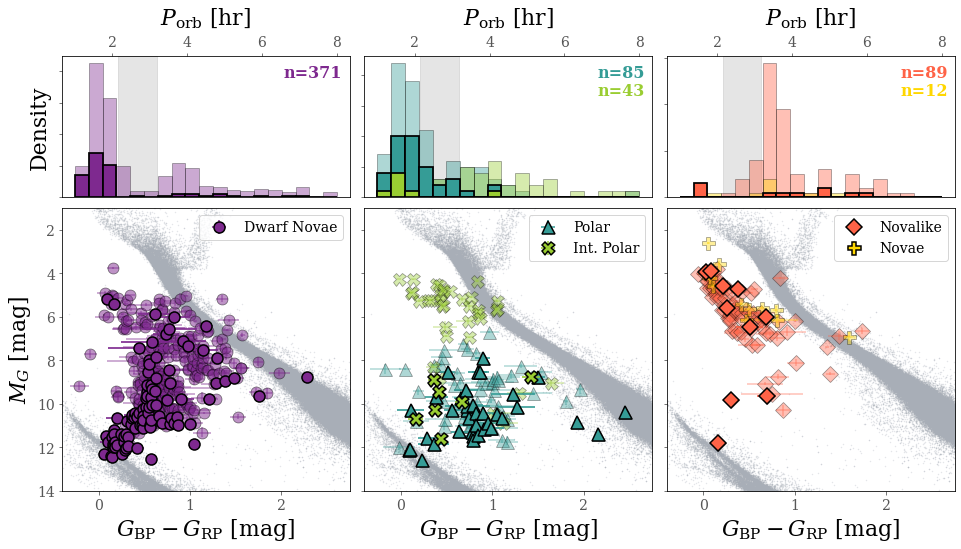

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, 
                         figsize=(16, 8), 
                         gridspec_kw={"height_ratios":[0.5, 1]})

## First Column, Upper Row

axes[0,0].hist(p_orb.loc[ug_mask], fc='#7e298f', ec='k', alpha=0.4, 
               lw=0.75, bins=np.linspace(1,8,20), zorder=1)

axes[0,0].hist(p_orb.loc[ug_mask & dist_mask], fc='#7e298f', ec='k', alpha=1.0, 
               lw=1.75, bins=np.linspace(1,8,20), zorder=2)
axes[0,0].axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

axes[0,0].annotate(r'n={}'.format(len(p_orb.loc[ug_mask])), 
                   xy=(0.77, 0.85), xycoords='axes fraction', 
                   fontweight='bold',
                   color='#7e298f', fontsize=16)

axes[0,0].set_ylabel('Density', fontsize=22)
axes[0,0].set_xlabel(r'$P_{\rm orb}$ [hr]', fontsize=22, labelpad=10)
axes[0,0].xaxis.set_ticks_position('top')
axes[0,0].xaxis.set_label_position('top') 
axes[0,0].set_yticklabels([])



## First Column, Lower Row

axes[1,0].scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7', 
                  alpha=0.3, s=1, zorder=-1, rasterized=True)

axes[1,0].errorbar(bp_rp.loc[ug_mask], 
                 abs_g.loc[ug_mask], 
                 yerr=[abs_g_lowlim.loc[ug_mask], 
                       abs_g_uplim.loc[ug_mask]], 
                 xerr=bp_rp_err.loc[ug_mask], 
                 fmt='o', color='#7e298f', ms=11, alpha = 0.5,
                 mec='k', mew=0.75, label='',
                 linewidth=1.5, zorder=1)

axes[1,0].errorbar(bp_rp.loc[ug_mask & dist_mask], 
                 abs_g.loc[ug_mask & dist_mask], 
                 yerr=[abs_g_lowlim.loc[ug_mask & dist_mask], 
                       abs_g_uplim.loc[ug_mask & dist_mask]], 
                 xerr=bp_rp_err.loc[ug_mask & dist_mask], 
                 fmt='o', color='#7e298f', ms=11,
                 mec='k', mew=1.5, label='Dwarf Novae',
                 linewidth=1.5, zorder=2)

axes[1,0].legend(loc='upper right', prop={'size': 14})
axes[1,0].set_xlim(-0.4, 2.75)
axes[1,0].set_ylim(14, 1)
axes[1,0].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]', fontsize=22)
axes[1,0].set_ylabel('$M_G$ [mag]', fontsize=22)


## Second Column, Upper Row

axes[0,1].hist(p_orb.loc[am_mask], fc='#359c96', ec='k', alpha=0.4, 
               lw=0.75, bins=np.linspace(1,8,20), zorder=1)

axes[0,1].hist(p_orb.loc[am_mask & dist_mask], fc='#359c96', ec='k', alpha=1.0, 
               lw=1.75, bins=np.linspace(1,8,20), zorder=3)

axes[0,1].hist(p_orb.loc[dq_mask], fc='#9acd32', ec='k', alpha=0.4, 
               lw=0.75, bins=np.linspace(1,8,20), zorder=2)

axes[0,1].hist(p_orb.loc[dq_mask & dist_mask], fc='#9acd32', ec='k', alpha=1.0, 
               lw=1.75, bins=np.linspace(1,8,20), zorder=4)


axes[0,1].axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

axes[0,1].annotate(r'n={}'.format(len(p_orb.loc[am_mask])), 
                   xy=(0.81, 0.85), xycoords='axes fraction', 
                   fontweight='bold',
                   color='#359c96', fontsize=16)
axes[0,1].annotate(r'n={}'.format(len(p_orb.loc[dq_mask])), 
                   xy=(0.81, 0.72), xycoords='axes fraction', 
                   fontweight='bold',
                   color='#9acd32', fontsize=16)

axes[0,1].set_xlabel(r'$P_{\rm orb}$ [hr]', fontsize=22, labelpad=10)
axes[0,1].xaxis.set_ticks_position('top')
axes[0,1].xaxis.set_label_position('top')
axes[0,1].set_yticklabels([])


## Second Column, Lower Row

axes[1,1].scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7', 
                alpha=0.3, s=1, zorder=-1, rasterized=True)

axes[1,1].errorbar(bp_rp.loc[am_mask], 
                 abs_g.loc[am_mask], 
                 yerr=[abs_g_lowlim.loc[am_mask], 
                       abs_g_uplim.loc[am_mask]], 
                 xerr=bp_rp_err.loc[am_mask], 
                 fmt='^', color='#359c96', ms=13, alpha=0.4,
                 mec='k', mew=0.75, label='',
                 linewidth=1.5, zorder=3)

axes[1,1].errorbar(bp_rp.loc[dq_mask], 
                 abs_g.loc[dq_mask], 
                 yerr=[abs_g_lowlim.loc[dq_mask], 
                       abs_g_uplim.loc[dq_mask]], 
                 xerr=bp_rp_err.loc[dq_mask], 
                 fmt='X', color='#9acd32', ms=13, alpha=0.4,
                 mec='k', mew=0.75, label='',
                 linewidth=1.5, zorder=4)

axes[1,1].errorbar(bp_rp.loc[am_mask & dist_mask], 
                 abs_g.loc[am_mask & dist_mask], 
                 yerr=[abs_g_lowlim.loc[am_mask & dist_mask], 
                       abs_g_uplim.loc[am_mask & dist_mask]], 
                 xerr=bp_rp_err.loc[am_mask & dist_mask], 
                 fmt='^', color='#359c96', ms=13,
                 mec='k', mew=1.5, label='Polar',
                 linewidth=1.5, zorder=5)

axes[1,1].errorbar(bp_rp.loc[dq_mask & dist_mask], 
                 abs_g.loc[dq_mask & dist_mask], 
                 yerr=[abs_g_lowlim.loc[dq_mask & dist_mask], 
                       abs_g_uplim.loc[dq_mask & dist_mask]], 
                 xerr=bp_rp_err.loc[dq_mask & dist_mask], 
                 fmt='X', color='#9acd32', ms=13,
                 mec='k', mew=1.5, label='Int. Polar',
                 linewidth=1.5, zorder=6)

axes[1,1].legend(loc='upper right', prop={'size': 14})
axes[1,1].set_xlim(-0.4, 2.75)
axes[1,1].set_ylim(14, 1)
axes[1,1].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]', fontsize=22)
axes[1,1].set_yticklabels([])

## Third Column, Upper Row

axes[0,2].hist(p_orb.loc[nl_mask], fc='#ff6347', ec='k', alpha=0.4, 
               lw=0.75, bins=np.linspace(1,8,20), zorder=1)

axes[0,2].hist(p_orb.loc[nl_mask & dist_mask], fc='#ff6347', ec='k', alpha=1.0, 
               lw=1.75, bins=np.linspace(1,8,20), zorder=3)

axes[0,2].hist(p_orb.loc[nov_mask], fc='#ffd700', ec='k', alpha=0.4, 
               lw=0.75, bins=np.linspace(1,8,20), zorder=2)

axes[0,2].hist(p_orb.loc[nov_mask & dist_mask], fc='#ffd700', ec='k', alpha=1.0, 
               lw=1.75, bins=np.linspace(1,8,20), zorder=4)


axes[0,2].axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

axes[0,2].annotate(r'n={}'.format(len(p_orb.loc[nl_mask])), 
                   xy=(0.81, 0.85), xycoords='axes fraction', 
                   fontweight='bold',
                   color='#ff6347', fontsize=16)
axes[0,2].annotate(r'n={}'.format(len(p_orb.loc[nov_mask])), 
                   xy=(0.81, 0.72), xycoords='axes fraction', 
                   fontweight='bold',
                   color='#ffd700', fontsize=16)

axes[0,2].set_xlabel(r'$P_{\rm orb}$ [hr]', fontsize=22, labelpad=10)
axes[0,2].xaxis.set_ticks_position('top')
axes[0,2].xaxis.set_label_position('top')
axes[0,2].set_yticklabels([])

## Third Plot

axes[1,2].scatter(nearby_bp_rp, nearby_absg, marker='.', c='#a8aeb7', 
                alpha=0.3, s=1, zorder=-1, rasterized=True)

axes[1,2].errorbar(bp_rp.loc[nl_mask], 
                 abs_g.loc[nl_mask], 
                 yerr=[abs_g_lowlim.loc[nl_mask], 
                       abs_g_uplim.loc[nl_mask]], 
                 xerr=bp_rp_err.loc[nl_mask], 
                 fmt='D', color='#ff6347', ms=11, alpha=0.4,
                 mec='k', mew=0.75, label='',
                 linewidth=1.5, zorder=7)

axes[1,2].errorbar(bp_rp.loc[nov_mask], 
                 abs_g.loc[nov_mask], 
                 yerr=[abs_g_lowlim.loc[nov_mask], 
                       abs_g_uplim.loc[nov_mask]], 
                 xerr=bp_rp_err.loc[nov_mask], 
                 fmt='P', color='#ffd700', ms=13, alpha=0.4,
                 mec='k', mew=0.75, label='',
                 linewidth=1.5, zorder=8)

axes[1,2].errorbar(bp_rp.loc[nl_mask & dist_mask], 
                 abs_g.loc[nl_mask & dist_mask], 
                 yerr=[abs_g_lowlim.loc[nl_mask & dist_mask], 
                       abs_g_uplim.loc[nl_mask & dist_mask]], 
                 xerr=bp_rp_err.loc[nl_mask & dist_mask], 
                 fmt='D', color='#ff6347', ms=11,
                 mec='k', mew=1.5, label='Novalike',
                 linewidth=1.5, zorder=9)

axes[1,2].errorbar(bp_rp.loc[nov_mask & dist_mask], 
                 abs_g.loc[nov_mask & dist_mask], 
                 yerr=[abs_g_lowlim.loc[nov_mask & dist_mask], 
                       abs_g_uplim.loc[nov_mask & dist_mask]], 
                 xerr=bp_rp_err.loc[nov_mask & dist_mask], 
                 fmt='P', color='#ffd700', ms=13,
                 mec='k', mew=1.5, label='Novae',
                 linewidth=1.5, zorder=10)

axes[1,2].legend(loc='upper right', prop={'size': 14})
axes[1,2].set_xlim(-0.4, 2.75)
axes[1,2].set_ylim(14, 1)
axes[1,2].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]', fontsize=22)
axes[1,2].set_yticklabels([])

plt.subplots_adjust(wspace=0.05, hspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/camd_types.pdf', bbox_inches = 'tight', pad_inches = 0.15)

Now run the fit for all **disked CVs** (UG + NL + Novae + DQ).

In [ ]:
p_orb_med = np.median(p_orb.loc[disk_mask])
abs_g_med = np.median(abs_g.loc[disk_mask])
bp_rp_med = np.median(bp_rp.loc[disk_mask])

p_orb_norm = p_orb.loc[disk_mask]/p_orb_med
abs_g_norm = abs_g.loc[disk_mask]/abs_g_med
bp_rp_norm = bp_rp.loc[disk_mask]/bp_rp_med

In [ ]:
np.random.seed(42)

def ln_like(theta, x_obs, xerr, y_obs, yerr, z_obs):
    beta_0, beta_x, beta_y, beta_xy = theta
    model = p_orb_med * beta_0 * np.exp(beta_x*(x_obs/bp_rp_med) 
                                        + beta_y*(y_obs/abs_g_med)
                                        + beta_xy*(x_obs/bp_rp_med)*(y_obs/abs_g_med)
                                       )
    
    uncertainties = np.sqrt(xerr**2 + yerr**2)
    
    ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))
    
    return ln_z

nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(bp_rp.loc[disk_mask], bp_rp_err.loc[disk_mask], 
                                    abs_g.loc[disk_mask], abs_g_geom_err.loc[disk_mask], 
                                    p_orb.loc[disk_mask]), method='BFGS')
beta_0_ml, beta_x_ml, beta_y_ml, beta_xy_ml = soln.x

In [ ]:
with pm.Model() as disked_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", sd=1) 
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    bX = pm.Normal("beta_bprp", beta_x_ml, sigma=10)
    bY = pm.Normal("beta_absg", beta_y_ml, sigma=10)
    bXY = pm.Normal("beta_xterm", beta_xy_ml, sigma=10)
    
    # Set X_i as RVs to incorporate their uncertainty
    obs_abs_g = pm.Normal('obs_abs_g', mu=abs_g_norm, 
                          sd=abs_g_geom_err.loc[disk_mask], 
                          shape=len(abs_g_norm))
    obs_bp_rp = pm.Normal('obs_bp_rp', mu=bp_rp_norm, 
                          sd=bp_rp_err.loc[disk_mask], 
                          shape=len(bp_rp_norm))

    # Define linear model
    y_est = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g +
                        bXY*(obs_bp_rp*obs_abs_g))

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=p_orb_norm
    )
    
    disked_trace = pm.sample(10000, cores=3, target_accept=0.9,
                             return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 386 seconds.
The number of effective samples is smaller than 25% for some parameters.


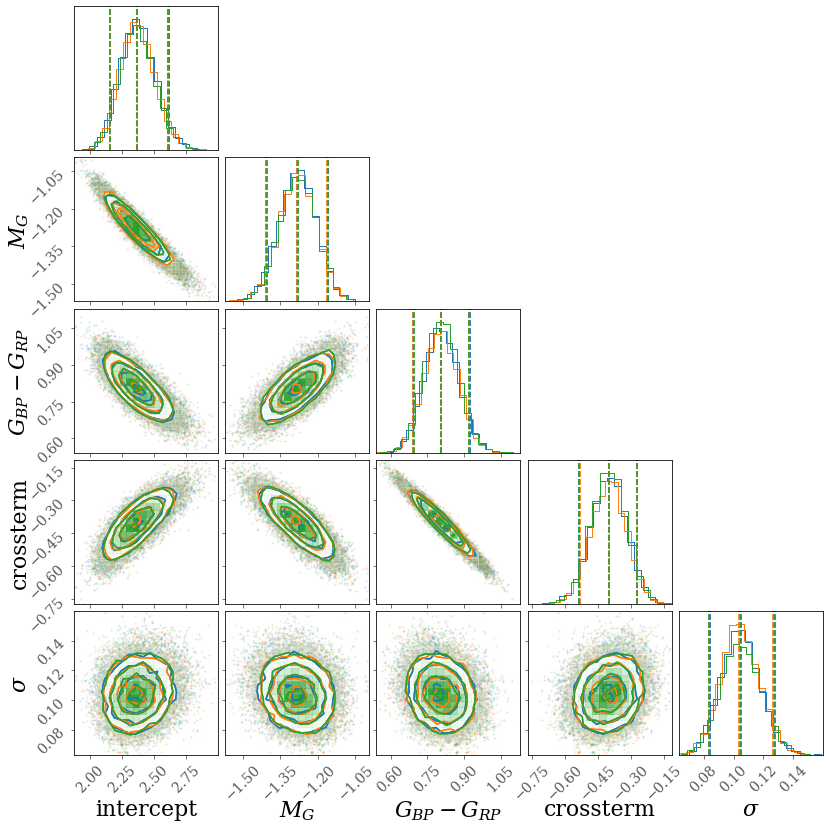

In [ ]:
fig = corner.corner(np.vstack((disked_trace.posterior.intercept[0],
                               disked_trace.posterior.beta_absg[0],
                               disked_trace.posterior.beta_bprp[0],
                               disked_trace.posterior.beta_xterm[0],
                               disked_trace.posterior.sigma[0])).T, 
                    labels = ['intercept', '$M_G$', 
                              '$G_{BP}-G_{RP}$', 'crossterm',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, fig=fig,
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((disked_trace.posterior.intercept[1],
                         disked_trace.posterior.beta_absg[1],
                         disked_trace.posterior.beta_bprp[1],
                         disked_trace.posterior.beta_xterm[1],
                         disked_trace.posterior.sigma[1])).T,
              fig=fig, color='#ff7f0e', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((disked_trace.posterior.intercept[2],
                         disked_trace.posterior.beta_absg[2],
                         disked_trace.posterior.beta_bprp[2],
                         disked_trace.posterior.beta_xterm[2],
                         disked_trace.posterior.sigma[2])).T,
              fig=fig, color='#2ca02c', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

In [ ]:
disked_trace_df = az.summary(disked_trace, 
                             hdi_prob = 0.68, 
                             round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                              'beta_xterm', 'sigma'], :]

In [ ]:
disked_trace_df

mean     sd  hdi_16%  ...   ess_bulk   ess_tail  r_hat
intercept   2.372  0.139    2.219  ...  12179.272  18520.123  1.000
beta_absg  -1.282  0.074   -1.354  ...  11406.408  18070.897  1.000
beta_bprp   0.806  0.070    0.735  ...   7296.374  13347.648  1.000
beta_xterm -0.402  0.080   -0.482  ...   7417.502  13252.825  1.000
sigma       0.105  0.013    0.092  ...   4806.516   8863.147  1.001

[5 rows x 9 columns]

In [ ]:
disked_trace_df['mean']['intercept']

2.372

In [ ]:
p_orb_hat_disked = p_orb_med * disked_trace_df['mean']['intercept'] * \
                       np.exp(disked_trace_df['mean']['beta_bprp']*(bp_rp/bp_rp_med) +
                              disked_trace_df['mean']['beta_absg']*(abs_g/abs_g_med) +
                              disked_trace_df['mean']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                             ) 
    
p_orb_hat_uplim_disked = ((p_orb_med * disked_trace_df['hdi_84%']['intercept'] * \
                           np.exp(disked_trace_df['hdi_84%']['beta_bprp']*(bp_rp/bp_rp_med) +
                                  disked_trace_df['hdi_84%']['beta_absg']*(abs_g/abs_g_med) +
                                  disked_trace_df['hdi_84%']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                                  )) - p_orb_hat_disked)*0.5

p_orb_hat_lolim_disked = (p_orb_hat_disked - (p_orb_med * disked_trace_df['hdi_16%']['intercept'] * \
                           np.exp(disked_trace_df['hdi_16%']['beta_bprp']*(bp_rp/bp_rp_med) +
                                  disked_trace_df['hdi_16%']['beta_absg']*(abs_g/abs_g_med) +
                                  disked_trace_df['hdi_16%']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                                 )))*0.5

p_orb_hat_sd = p_orb_med * disked_trace_df['sd']['intercept'] * \
                 np.exp(disked_trace_df['sd']['beta_bprp']*(bp_rp/bp_rp_med) +
                        disked_trace_df['sd']['beta_absg']*(abs_g/abs_g_med) +
                        disked_trace_df['sd']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                       ) 

In [ ]:
predict_mask = (p_orb_hat_disked < 8)

Text(0, 0.5, 'Fitted $\\hat{P}_{\\rm orb, disks}$ [hr]')

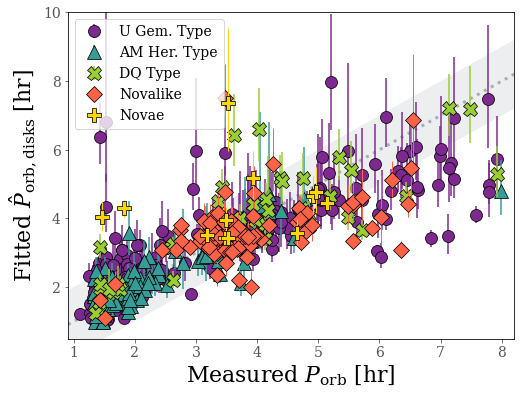

In [ ]:
plt.figure(figsize=(8,6))

plt.errorbar(p_orb.loc[ug_mask & predict_mask], 
             p_orb_hat_disked.loc[ug_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_disked.loc[ug_mask & predict_mask], 
                   p_orb_hat_uplim_disked.loc[ug_mask & predict_mask]],
#              yerr = p_orb_hat_sd.loc[ug_mask & predict_mask],
             fmt='o', color='#7e298f', ms=12,
             mec='k', mew=0.75, label='U Gem. Type',
             linewidth=1.5, zorder=1)

plt.errorbar(p_orb.loc[am_mask & predict_mask], 
             p_orb_hat_disked.loc[am_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_disked.loc[am_mask & predict_mask], 
                   p_orb_hat_uplim_disked.loc[am_mask & predict_mask]], 
#              yerr = p_orb_hat_sd.loc[am_mask & predict_mask],
             fmt='^', color='#359c96', ms=14,
             mec='k', mew=0.75, label='AM Her. Type',
             linewidth=1.5, zorder=2)

plt.errorbar(p_orb.loc[dq_mask & predict_mask], 
             p_orb_hat_disked.loc[dq_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_disked.loc[dq_mask & predict_mask], 
                   p_orb_hat_uplim_disked.loc[dq_mask & predict_mask]], 
#              yerr = p_orb_hat_sd.loc[dq_mask & predict_mask],
             fmt='X', color='#9acd32', ms=14,
             mec='k', mew=0.75, label='DQ Type',
             linewidth=1.5, zorder=3)

plt.errorbar(p_orb.loc[nl_mask & predict_mask], 
             p_orb_hat_disked.loc[nl_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_disked.loc[nl_mask & predict_mask], 
                   p_orb_hat_uplim_disked.loc[nl_mask & predict_mask]],
#              yerr = p_orb_hat_sd.loc[nl_mask & predict_mask],
             fmt='D', color='#ff6347', ms=12,
             mec='k', mew=0.75, label='Novalike',
             linewidth=1, zorder=4)

plt.errorbar(p_orb.loc[nov_mask & predict_mask], 
             p_orb_hat_disked.loc[nov_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_disked.loc[nov_mask & predict_mask], 
                   p_orb_hat_uplim_disked.loc[nov_mask & predict_mask]],  
#              yerr = p_orb_hat_sd.loc[nov_mask & predict_mask],
             fmt='P', color='#ffd700', ms=14,
             mec='k', mew=0.75, label='Novae',
             linewidth=1, zorder=5)

plt.plot([0,10],[0,10], c='#a8aeb7', lw=3, ls=':', zorder=0)
plt.fill_between([0,10],[-1,9],[1,11], fc='#a8aeb7', alpha=0.2, zorder=-1)

plt.legend(prop={'size': 14})
plt.xlim(0.9, 8.2)
plt.ylim(0.5, 10)
plt.xlabel(r'Measured $P_{\rm orb}$ [hr]', fontsize=22)
plt.ylabel(r'Fitted $\hat{P}_{\rm orb, disks}$ [hr]', fontsize=22)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


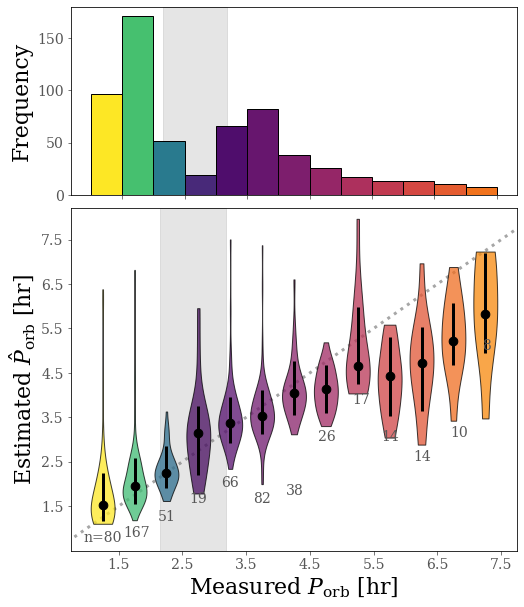

In [ ]:
p_orb_for_est = p_orb.loc[(p_orb_hat_disked < 8) & (p_orb_hat_disked > 1.1)]
p_orb_hat = p_orb_hat_disked.loc[(p_orb_hat_disked < 8) & (p_orb_hat_disked > 1.1)]


fig, (ax, ax2) = plt.subplots(nrows=2,figsize=(8, 10), 
                                   gridspec_kw={"height_ratios":[0.55, 1]})

#Upper Subplot

n, bins, patches = ax.hist(vsx_df['period']*24, bins=np.arange(1.0, 8.0, 0.5),
                            fc='Tomato', ec='k')
for i, p in enumerate(patches):
    plt.setp(p, 'facecolor', cv_map(i/len(np.arange(1.0, 8.0, 0.5))))

ax.set_ylabel('Frequency', fontsize=22)
ax.axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

ax.set_xticks(np.arange(1.5, 8.5, 1))
ax.set_xticklabels(np.repeat('', 7))


#------------------------------------------------------------------

#Lower Subplot


porb_1 = p_orb_hat.loc[(p_orb_for_est >= 1) & (p_orb_for_est < 1.5)]
porb_15 = p_orb_hat.loc[(p_orb_for_est >= 1.5) & (p_orb_for_est < 2)]
porb_2 = p_orb_hat.loc[(p_orb_for_est >= 2) & (p_orb_for_est < 2.5)]
porb_25 = p_orb_hat.loc[(p_orb_for_est >= 2.5) & (p_orb_for_est < 3)]
porb_3 = p_orb_hat.loc[(p_orb_for_est >= 3) & (p_orb_for_est < 3.5)]
porb_35 = p_orb_hat.loc[(p_orb_for_est >= 3.5) & (p_orb_for_est < 4)]
porb_4 = p_orb_hat.loc[(p_orb_for_est >= 4) & (p_orb < 4.5)]
porb_45 = p_orb_hat.loc[(p_orb >= 4.5) & (p_orb_for_est < 5)]
porb_5 = p_orb_hat.loc[(p_orb_for_est >= 5) & (p_orb_for_est < 5.5)]
porb_55 = p_orb_hat.loc[(p_orb_for_est >= 5.5) & (p_orb_for_est < 6)]
porb_6 = p_orb_hat.loc[(p_orb_for_est >= 6) & (p_orb_for_est < 6.5)]
porb_65 = p_orb_hat.loc[(p_orb_for_est >= 6.5) & (p_orb_for_est < 7)]
porb_7 = p_orb_hat.loc[(p_orb_for_est >= 7) & (p_orb_for_est < 7.5)]

## combine these different collections into a list
violin_bins = np.array([porb_1.values, porb_15.values, porb_2.values, porb_25.values,
                        porb_3.values, porb_35.values, porb_4.values, porb_45.values,
                        porb_5.values, porb_55.values, porb_6.values, porb_65.values,
                        porb_7.values])

bp = ax2.violinplot(violin_bins, widths=0.75,
                    showmeans=False, showmedians=False, 
                    showextrema=False)#.set_zorder(10)

colors = [cv_map((1.*i/len(violin_bins))) for i in range(len(violin_bins))]
iter_colors = itertools.cycle(colors)

for pc in bp['bodies']:
    color = list(next(iter_colors))
    color[3]=0.8
    pc.set_facecolor(tuple(color))
    pc.set_edgecolor('k')
    pc.set_alpha(0.75)
    
percentiles=[]   
for ii in range(len(violin_bins)):
    percentiles.append(np.percentile(violin_bins[ii], [12.5, 50, 87.5]))

quartile1, medians, quartile3 = np.array(percentiles)[:,0],np.array(percentiles)[:,1], np.array(percentiles)[:,2]
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(violin_bins, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='k', s=75, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=3)

#these lines define the transformation between xcoord axis and number line
ax2.set_xticks(np.arange(1.5, 15.5, 2))
ax2.set_xticklabels(np.arange(1.5, 8.5, 1))


#transform the gap limits into the x coordinate system
ax2.axvspan(2.80, 4.86, alpha=0.2, color='Grey', zorder=0) 
ax2.plot([-0.5,15.5], [0.5,8.5], c='k', 
         ls=':', lw=3, alpha=0.35,
         zorder=-1) #recast to accomodate x coordinate system

ax2.set_yticks(np.arange(1.5, 8.5, 1))

ax2.set_xlim(0, 14)
ax2.set_ylim(0.5, 8.2)

#annotations
ax2.annotate('n='+str(len(porb_1)), (0.4, 0.7), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_15)), (1.65, 0.81), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_2)), (2.73, 1.18), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_25)), (3.73, 1.58), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_3)), (4.73, 1.93), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_35)), (5.73, 1.58), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_4)), (6.74, 1.75), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_45)), (7.74, 2.96), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_5)), (8.84, 3.8), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_55)), (9.74, 2.97), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_6)), (10.74, 2.52), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_65)), (11.9, 3.05), fontsize=14, c='#575757')
ax2.annotate(str(len(porb_7)), (12.9, 5.01), fontsize=14, c='#575757')



ax2.set_xlabel(r'Measured $P_{\rm orb}$ [hr]')
ax2.set_ylabel(r'Estimated $\hat{P}_{\rm orb}$ [hr]')

plt.subplots_adjust(hspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/rk_gof_disked.pdf', bbox_inches = 'tight', pad_inches = 0.15)

Now run the fit for **non-disked CVs** (AM).

In [ ]:
p_orb_med = np.median(p_orb.loc[am_mask])
abs_g_med = np.median(abs_g.loc[am_mask])
bp_rp_med = np.median(bp_rp.loc[am_mask])

p_orb_norm = p_orb.loc[am_mask]/p_orb_med
abs_g_norm = abs_g.loc[am_mask]/abs_g_med
bp_rp_norm = bp_rp.loc[am_mask]/bp_rp_med

In [ ]:
np.random.seed(42)

def ln_like(theta, x_obs, xerr, y_obs, yerr, z_obs):
    beta_0, beta_x, beta_y, beta_xy = theta
    model = p_orb_med * beta_0 * np.exp(beta_x*((x_obs)/bp_rp_med) 
                                        + beta_y*(y_obs/abs_g_med)
                                        + beta_xy*(x_obs/bp_rp_med)*(y_obs/abs_g_med)
                                       )
    
    uncertainties = np.sqrt(xerr**2 + yerr**2)
    
    ln_z = -0.5 * np.sum(((z_obs - model) / uncertainties)**2 + np.log(2*np.pi) + np.log(uncertainties))
    
    return ln_z

nll = lambda *args: -ln_like(*args)
initial = np.repeat(0.0,4) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(bp_rp.loc[am_mask], bp_rp_err.loc[am_mask], 
                                    abs_g.loc[am_mask], abs_g_geom_err.loc[am_mask], 
                                    p_orb.loc[am_mask]), method='BFGS')
beta_0_ml, beta_x_ml, beta_y_ml, beta_xy_ml = soln.x

In [ ]:
print(beta_0_ml, beta_x_ml, beta_y_ml, beta_xy_ml)

1.288210270083373 1.6470112798519996 -0.5196084111519483 -1.2515808711951817


In [ ]:
with pm.Model() as undisked_model:

    # Define weakly informative Normal priors for Ridge regression
    sigma = pm.HalfNormal("sigma", sd=1) 
    b0 = pm.Normal("intercept", beta_0_ml, sigma=10)
    bX = pm.Normal("beta_bprp", beta_x_ml, sigma=10)
    bY = pm.Normal("beta_absg", beta_y_ml, sigma=10)
    bXY = pm.Normal("beta_xterm", beta_xy_ml, sigma=10)
    
    # Set X_i as RVs to incorporate their uncertainty
    obs_abs_g = pm.Normal('obs_abs_g', mu=abs_g_norm, 
                          sd=abs_g_geom_err.loc[am_mask], 
                          shape=len(abs_g_norm))
    obs_bp_rp = pm.Normal('obs_bp_rp', mu=bp_rp_norm, 
                          sd=bp_rp_err.loc[am_mask], 
                          shape=len(bp_rp_norm))

    # Define linear model
    y_est = b0 * np.exp(bX*obs_bp_rp + bY*obs_abs_g +
                        bXY*(obs_bp_rp*obs_abs_g))

    # Define prior for StudentT degrees of freedom
    # Inverse Gamma is recommended
    nu = pm.InverseGamma("nu", alpha=1, beta=1)

    # Define Student T likelihood
    likelihood = pm.StudentT(
        "likelihood", mu=y_est, sigma=sigma, nu=nu, observed=p_orb_norm
    )
    
    undisked_trace = pm.sample(10000, cores=3, target_accept=0.9,
                               return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, obs_bp_rp, obs_abs_g, beta_xterm, beta_absg, beta_bprp, intercept, sigma]


Sampling 3 chains for 1_000 tune and 10_000 draw iterations (3_000 + 30_000 draws total) took 995 seconds.
The number of effective samples is smaller than 10% for some parameters.


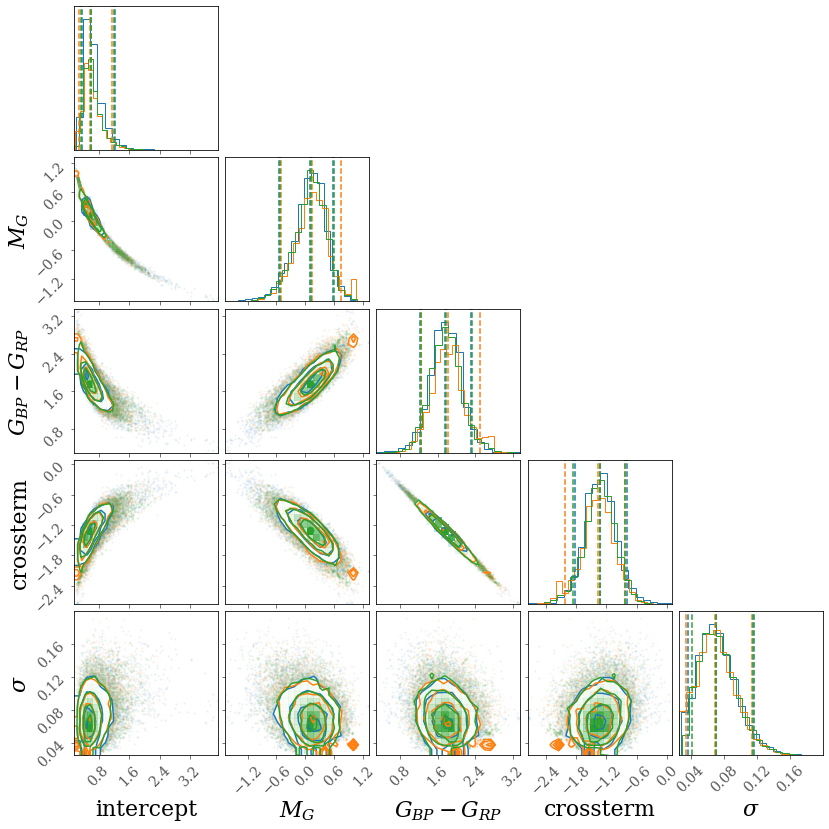

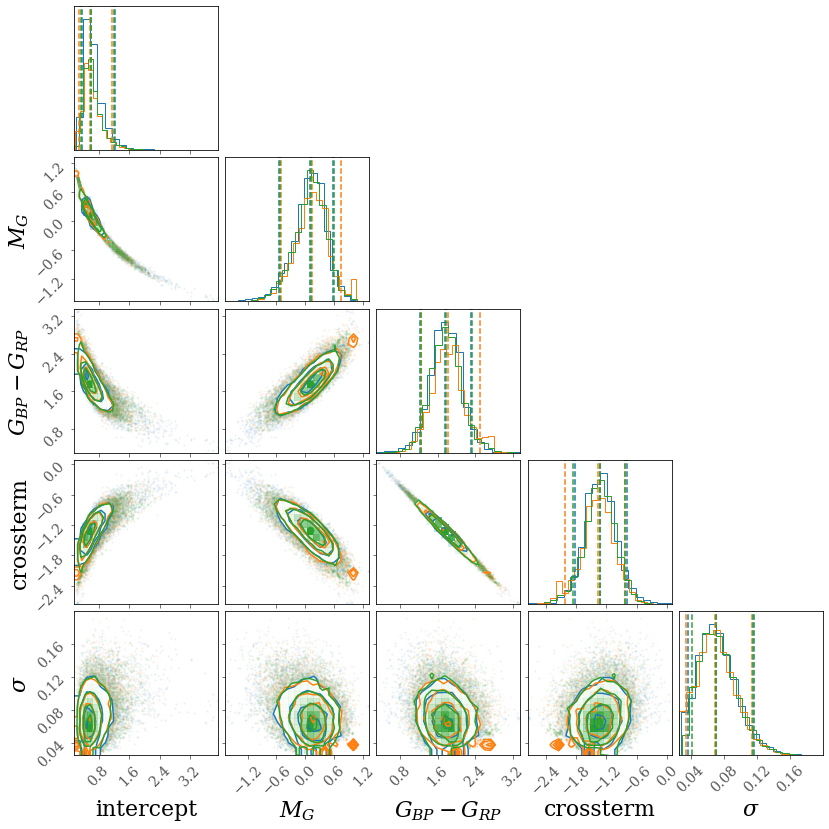

In [ ]:
fig = corner.corner(np.vstack((undisked_trace.posterior.intercept[0],
                               undisked_trace.posterior.beta_absg[0],
                               undisked_trace.posterior.beta_bprp[0],
                               undisked_trace.posterior.beta_xterm[0],
                               undisked_trace.posterior.sigma[0])).T, 
                    labels = ['intercept', '$M_G$', 
                              '$G_{BP}-G_{RP}$', 'crossterm',
                              '$\sigma$'], color='#1f77b4',
                    alpha=0.25, #fig=fig,
                    label_kwargs={"fontsize": 22, "labelpad": 5}, 
                    quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((undisked_trace.posterior.intercept[1],
                         undisked_trace.posterior.beta_absg[1],
                         undisked_trace.posterior.beta_bprp[1],
                         undisked_trace.posterior.beta_xterm[1],
                         undisked_trace.posterior.sigma[1])).T,
              fig=fig, color='#ff7f0e', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

corner.corner(np.vstack((undisked_trace.posterior.intercept[2],
                         undisked_trace.posterior.beta_absg[2],
                         undisked_trace.posterior.beta_bprp[2],
                         undisked_trace.posterior.beta_xterm[2],
                         undisked_trace.posterior.sigma[2])).T,
              fig=fig, color='#2ca02c', alpha=0.25,
              quantiles=[0.05, 0.5, 0.95])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f959c1c3ad0>,
      dtype=object)

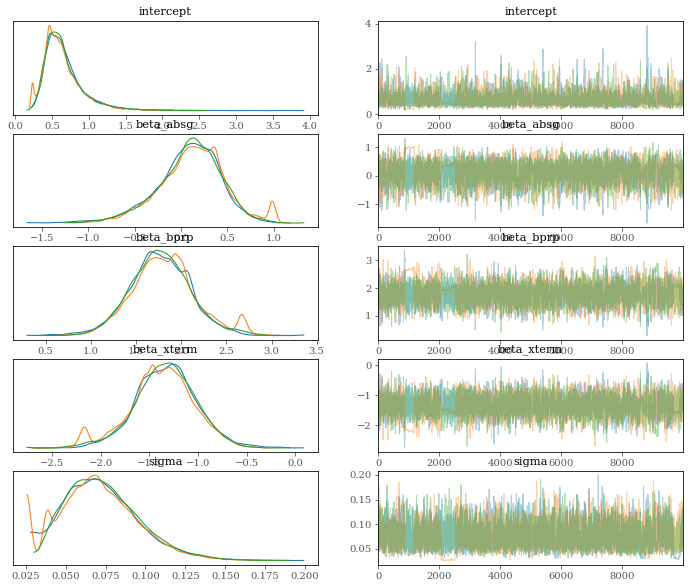

In [ ]:
az.plot_trace(undisked_trace, 
              var_names=['intercept', 'beta_absg', 
                         'beta_bprp', 'beta_xterm', 
                         'sigma'], 
              combined=False, compact=False)

In [ ]:
undisked_trace_df = az.summary(undisked_trace, 
                               hdi_prob = 0.68, 
                               round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                'beta_xterm', 'sigma'], :]

In [ ]:
p_orb_hat_undisked = p_orb_med * undisked_trace_df['mean']['intercept'] * \
                       np.exp(undisked_trace_df['mean']['beta_bprp']*((bp_rp)/bp_rp_med) +
                              undisked_trace_df['mean']['beta_absg']*(abs_g/abs_g_med) +
                              undisked_trace_df['mean']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                             ) 
    
p_orb_hat_uplim_undisked = ((p_orb_med * undisked_trace_df['hdi_84%']['intercept'] * \
                           np.exp(undisked_trace_df['hdi_84%']['beta_bprp']*(bp_rp/bp_rp_med) +
                                  undisked_trace_df['hdi_84%']['beta_absg']*(abs_g/abs_g_med) +
                                  undisked_trace_df['hdi_84%']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                                  )) - p_orb_hat_undisked)*0.5

p_orb_hat_lolim_undisked = (p_orb_hat_undisked - (p_orb_med * undisked_trace_df['hdi_16%']['intercept'] * \
                               np.exp(undisked_trace_df['hdi_16%']['beta_bprp']*(bp_rp/bp_rp_med) +
                                      undisked_trace_df['hdi_16%']['beta_absg']*(abs_g/abs_g_med) +
                                      undisked_trace_df['hdi_16%']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                                     )))*0.5

p_orb_hat_sd_undisked = p_orb_med * undisked_trace_df['sd']['intercept'] * \
                         np.exp(undisked_trace_df['sd']['beta_bprp']*(bp_rp/bp_rp_med) +
                                undisked_trace_df['sd']['beta_absg']*(abs_g/abs_g_med) +
                                undisked_trace_df['sd']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                               ) 

predict_mask = (p_orb_hat_undisked < 8)

Text(0, 0.5, 'Fitted $\\hat{P}_{\\rm orb | AM}$ [hr]')

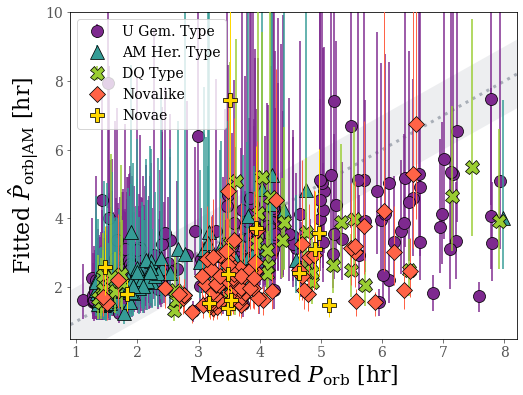

In [ ]:
plt.figure(figsize=(8,6))

plt.errorbar(p_orb.loc[ug_mask & predict_mask], 
             p_orb_hat_undisked.loc[ug_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_undisked.loc[ug_mask & predict_mask], 
                   p_orb_hat_uplim_undisked.loc[ug_mask & predict_mask]],
#              yerr = p_orb_hat_sd.loc[ug_mask & predict_mask],
             fmt='o', color='#7e298f', ms=12,
             mec='k', mew=0.75, label='U Gem. Type',
             linewidth=1.5, zorder=1)

plt.errorbar(p_orb.loc[am_mask & predict_mask], 
             p_orb_hat_undisked.loc[am_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_undisked.loc[am_mask & predict_mask], 
                   p_orb_hat_uplim_undisked.loc[am_mask & predict_mask]], 
#              yerr = p_orb_hat_sd.loc[am_mask & predict_mask],
             fmt='^', color='#359c96', ms=14,
             mec='k', mew=0.75, label='AM Her. Type',
             linewidth=1.5, zorder=2)

plt.errorbar(p_orb.loc[dq_mask & predict_mask], 
             p_orb_hat_undisked.loc[dq_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_undisked.loc[dq_mask & predict_mask], 
                   p_orb_hat_uplim_undisked.loc[dq_mask & predict_mask]], 
#              yerr = p_orb_hat_sd.loc[dq_mask & predict_mask],
             fmt='X', color='#9acd32', ms=14,
             mec='k', mew=0.75, label='DQ Type',
             linewidth=1.5, zorder=3)

plt.errorbar(p_orb.loc[nl_mask & predict_mask], 
             p_orb_hat_undisked.loc[nl_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_undisked.loc[nl_mask & predict_mask], 
                   p_orb_hat_uplim_undisked.loc[nl_mask & predict_mask]],
#              yerr = p_orb_hat_sd.loc[nl_mask & predict_mask],
             fmt='D', color='#ff6347', ms=12,
             mec='k', mew=0.75, label='Novalike',
             linewidth=1, zorder=4)

plt.errorbar(p_orb.loc[nov_mask & predict_mask], 
             p_orb_hat_undisked.loc[nov_mask & predict_mask], 
             yerr=[p_orb_hat_lolim_undisked.loc[nov_mask & predict_mask], 
                   p_orb_hat_uplim_undisked.loc[nov_mask & predict_mask]],  
#              yerr = p_orb_hat_sd.loc[nov_mask & predict_mask],
             fmt='P', color='#ffd700', ms=14,
             mec='k', mew=0.75, label='Novae',
             linewidth=1, zorder=5)

plt.plot([0,10],[0,10], c='#a8aeb7', lw=3, ls=':', zorder=0)
plt.fill_between([0,10],[-1,9],[1,11], fc='#a8aeb7', alpha=0.2, zorder=-1)

# plt.plot([0,10],[-1,9], c='Grey', lw=3, ls=':', zorder=0, alpha=0.3)
# plt.plot([0,10],[1,11], c='Grey', lw=3, ls=':', zorder=0, alpha=0.3)

plt.legend(prop={'size': 14})
plt.xlim(0.9, 8.2)
plt.ylim(0.5, 10)
plt.xlabel(r'Measured $P_{\rm orb}$ [hr]', fontsize=22)
plt.ylabel(r'Fitted $\hat{P}_{\rm orb | AM}$ [hr]', fontsize=22)

To make this all easier to understand, I'm going to do a stacked version with overall fit, disked and diskless.

In [ ]:
edr3_trace_df = az.summary(edr3_trace, hdi_prob = 0.68, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                                         'beta_xterm', 'sigma'], :]

Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [ ]:
p_orb_hat = p_orb_med * edr3_trace_df['mean']['intercept'] * \
                       np.exp(edr3_trace_df['mean']['beta_bprp']*(bp_rp/bp_rp_med) +
                              edr3_trace_df['mean']['beta_absg']*(abs_g/abs_g_med) +
                              edr3_trace_df['mean']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                             ) 
    
p_orb_hat_uplim= ((p_orb_med * edr3_trace_df['hdi_84%']['intercept'] * \
                           np.exp(edr3_trace_df['hdi_84%']['beta_bprp']*(bp_rp/bp_rp_med) +
                                  edr3_trace_df['hdi_84%']['beta_absg']*(abs_g/abs_g_med) +
                                  edr3_trace_df['hdi_84%']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                                  )) - p_orb_hat)*0.5 #cast onto z-scale

p_orb_hat_lolim = (p_orb_hat - (p_orb_med * edr3_trace_df['hdi_16%']['intercept'] * \
                           np.exp(edr3_trace_df['hdi_16%']['beta_bprp']*(bp_rp/bp_rp_med) +
                                  edr3_trace_df['hdi_16%']['beta_absg']*(abs_g/abs_g_med) +
                                  edr3_trace_df['hdi_16%']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                                 )))*0.5 #cast onto z-scale

p_orb_hat_sd = p_orb_med * edr3_trace_df['sd']['intercept'] * \
                 np.exp(edr3_trace_df['sd']['beta_bprp']*(bp_rp/bp_rp_med) +
                        edr3_trace_df['sd']['beta_absg']*(abs_g/abs_g_med) +
                        edr3_trace_df['sd']['beta_xterm']*(bp_rp/bp_rp_med)*(abs_g/abs_g_med)
                       ) 

In [ ]:
len(p_orb_hat)

623

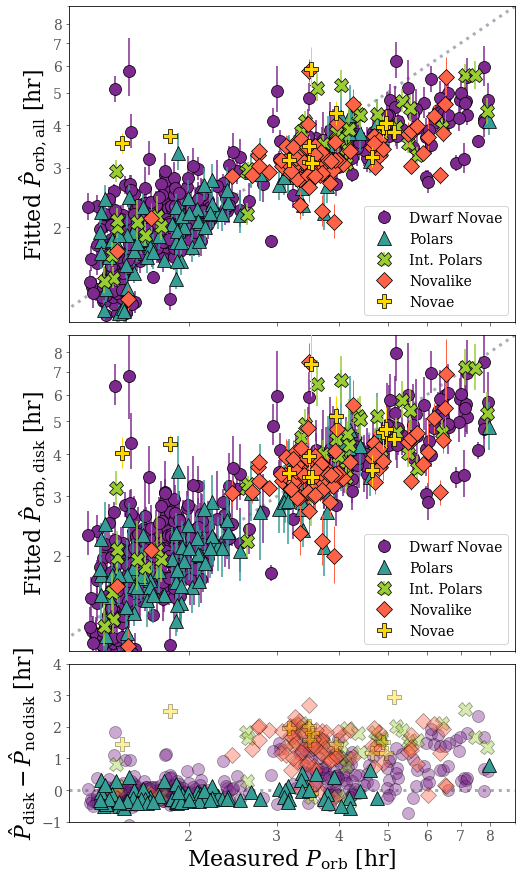

In [ ]:
fig, axes = plt.subplots(3, 1, sharex=True, 
                         gridspec_kw={'height_ratios': [2,2,1]},
                         figsize=(8,15))


axes[0].errorbar(p_orb.loc[ug_mask & predict_mask], 
                 p_orb_hat.loc[ug_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim.loc[ug_mask & predict_mask], 
                       p_orb_hat_uplim.loc[ug_mask & predict_mask]],
                 fmt='o', color='#7e298f', ms=12,
                 mec='k', mew=0.75, label='Dwarf Novae',
                 linewidth=1.5, zorder=1)

axes[0].errorbar(p_orb.loc[am_mask & predict_mask], 
                 p_orb_hat.loc[am_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim.loc[am_mask & predict_mask], 
                       p_orb_hat_uplim.loc[am_mask & predict_mask]], 
                 fmt='^', color='#359c96', ms=14,
                 mec='k', mew=0.75, label='Polars',
                 linewidth=1.5, zorder=2)

axes[0].errorbar(p_orb.loc[dq_mask & predict_mask], 
                 p_orb_hat.loc[dq_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim.loc[dq_mask & predict_mask], 
                       p_orb_hat_uplim.loc[dq_mask & predict_mask]], 
                 fmt='X', color='#9acd32', ms=14,
                 mec='k', mew=0.75, label='Int. Polars',
                 linewidth=1.5, zorder=3)

axes[0].errorbar(p_orb.loc[nl_mask & predict_mask], 
                 p_orb_hat.loc[nl_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim.loc[nl_mask & predict_mask], 
                       p_orb_hat_uplim.loc[nl_mask & predict_mask]],
                 fmt='D', color='#ff6347', ms=12,
                 mec='k', mew=0.75, label='Novalike',
                 linewidth=1, zorder=4)

axes[0].errorbar(p_orb.loc[nov_mask & predict_mask], 
                 p_orb_hat.loc[nov_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim.loc[nov_mask & predict_mask], 
                       p_orb_hat_uplim.loc[nov_mask & predict_mask]],  
                 fmt='P', color='#ffd700', ms=14,
                 mec='k', mew=0.75, label='Novae',
                 linewidth=1, zorder=5)

axes[0].plot([-1,10],[-1,10], c='#a8aeb7', lw=3, ls=':', zorder=0)

axes[0].legend(loc='lower right', prop={'size': 14}).set_zorder(20)
axes[0].set_yscale('log')
axes[0].set_xscale('log')

axes[0].set_xlim(1.15, 9)
axes[0].set_ylim(1.05, 9)
axes[0].set_yticks(np.arange(2,9,1))
axes[0].set_xticks(np.arange(2,9,1))
axes[0].set_yticklabels(np.arange(2,9,1))
axes[0].set_ylabel(r'Fitted $\hat{P}_{\rm orb, all}$ [hr]', fontsize=22)

axes[1].errorbar(p_orb.loc[ug_mask & predict_mask], 
                 p_orb_hat_disked.loc[ug_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim_disked.loc[ug_mask & predict_mask], 
                       p_orb_hat_uplim_disked.loc[ug_mask & predict_mask]],
                 fmt='o', color='#7e298f', ms=12,
                 mec='k', mew=0.75, label='Dwarf Novae',
                 linewidth=1.5, zorder=1)

axes[1].errorbar(p_orb.loc[am_mask & predict_mask], 
                 p_orb_hat_disked.loc[am_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim_disked.loc[am_mask & predict_mask], 
                       p_orb_hat_uplim_disked.loc[am_mask & predict_mask]], 
                 fmt='^', color='#359c96', ms=14,
                 mec='k', mew=0.75, label='Polars',
                 linewidth=1.5, zorder=2)

axes[1].errorbar(p_orb.loc[dq_mask & predict_mask], 
                 p_orb_hat_disked.loc[dq_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim_disked.loc[dq_mask & predict_mask], 
                       p_orb_hat_uplim_disked.loc[dq_mask & predict_mask]], 
                 fmt='X', color='#9acd32', ms=14,
                 mec='k', mew=0.75, label='Int. Polars',
                 linewidth=1.5, zorder=3)

axes[1].errorbar(p_orb.loc[nl_mask & predict_mask], 
                 p_orb_hat_disked.loc[nl_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim_disked.loc[nl_mask & predict_mask], 
                       p_orb_hat_uplim_disked.loc[nl_mask & predict_mask]],
                 fmt='D', color='#ff6347', ms=12,
                 mec='k', mew=0.75, label='Novalike',
                 linewidth=1, zorder=4)

axes[1].errorbar(p_orb.loc[nov_mask & predict_mask], 
                 p_orb_hat_disked.loc[nov_mask & predict_mask], 
                 yerr=[p_orb_hat_lolim_disked.loc[nov_mask & predict_mask], 
                       p_orb_hat_uplim_disked.loc[nov_mask & predict_mask]],  
                 fmt='P', color='#ffd700', ms=14,
                 mec='k', mew=0.75, label='Novae',
                 linewidth=1, zorder=5)

axes[1].plot([-1,10],[-1,10], c='#a8aeb7', lw=3, ls=':', zorder=0)

axes[1].legend(loc='lower right', prop={'size': 14}).set_zorder(20)
axes[1].set_yscale('log')
axes[1].set_xscale('log')

axes[1].set_xlim(1.15, 9)
axes[1].set_ylim(1.05, 9)
axes[1].set_yticks(np.arange(2,9,1))
axes[1].set_xticks(np.arange(2,9,1))
axes[1].set_yticklabels(np.arange(2,9,1))
axes[1].set_ylabel(r'Fitted $\hat{P}_{\rm orb, disk}$ [hr]', fontsize=22)

axes[2].errorbar(p_orb.loc[ug_mask & predict_mask], 
                 p_orb_hat_disked.loc[ug_mask & predict_mask] - p_orb_hat_undisked.loc[ug_mask & predict_mask], 
                 fmt='o', color='#7e298f', ms=12, alpha=0.4,
                 mec='k', mew=0.75, label='U Gem. Type',
                 linewidth=1.5, zorder=1)

axes[2].errorbar(p_orb.loc[am_mask & predict_mask], 
                 p_orb_hat_disked.loc[am_mask & predict_mask] - p_orb_hat_undisked.loc[am_mask & predict_mask], 
                 fmt='^', color='#359c96', ms=14,
                 mec='k', mew=0.75, label='AM Her. Type',
                 linewidth=1.5, zorder=6)

axes[2].errorbar(p_orb.loc[dq_mask & predict_mask], 
                 p_orb_hat_disked.loc[dq_mask & predict_mask] - p_orb_hat_undisked.loc[dq_mask & predict_mask], 
                 fmt='X', color='#9acd32', ms=14, alpha=0.4,
                 mec='k', mew=0.75, label='DQ Type',
                 linewidth=1.5, zorder=3)

axes[2].errorbar(p_orb.loc[nl_mask & predict_mask], 
                 p_orb_hat_disked.loc[nl_mask & predict_mask] - p_orb_hat_undisked.loc[nl_mask & predict_mask], 
                 fmt='D', color='#ff6347', ms=12, alpha=0.4,
                 mec='k', mew=0.75, label='Novalike',
                 linewidth=1, zorder=4)

axes[2].errorbar(p_orb.loc[nov_mask & predict_mask], 
                 p_orb_hat_disked.loc[nov_mask & predict_mask] - p_orb_hat_undisked.loc[nov_mask & predict_mask], 
                 fmt='P', color='#ffd700', ms=14, alpha=0.4,
                 mec='k', mew=0.75, label='Novae',
                 linewidth=1, zorder=5)

axes[2].set_ylabel(r'$\hat{P}_{\rm disk} - \hat{P}_{\rm no\, disk}$ [hr]', fontsize=22)
axes[2].set_xlabel(r'Measured $P_{\rm orb}$ [hr]', fontsize=22)
axes[2].set_ylim(-1,4)
axes[2].set_xticklabels(np.arange(2,9,1))

axes[2].axhline(0, c='#a8aeb7', lw=3, ls=':', zorder=0)

plt.subplots_adjust(hspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/types_fit.pdf', bbox_inches = 'tight', pad_inches = 0.15)

### Semi-Empirical Donor Sequence by Type

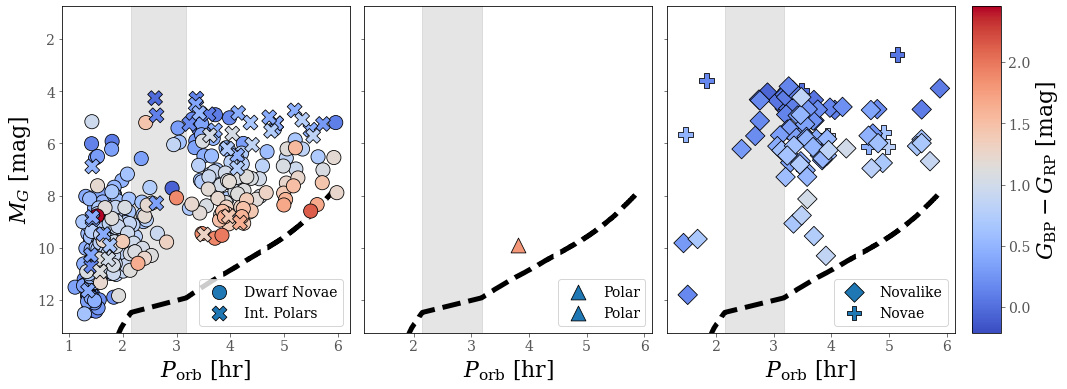

In [ ]:
fig, axes = plt.subplots(ncols=3, 
                         figsize=(16, 6), sharey=True)

##------------
## Left Panel

knigge_mask = p_orb < 6

cb = axes[0].scatter(p_orb.loc[ug_mask & knigge_mask], 
                     abs_g.loc[ug_mask & knigge_mask], 
                     c=bp_rp.loc[ug_mask & knigge_mask], 
                     cmap='coolwarm', s=200,
                     alpha=1, edgecolor='k', linewidth=0.8,
                     label='Dwarf Novae', zorder=1)

cb = axes[0].scatter(p_orb.loc[dq_mask & knigge_mask], 
                     abs_g.loc[dq_mask & knigge_mask], 
                     c=bp_rp.loc[dq_mask & knigge_mask], 
                     cmap='coolwarm', s=220, marker='X',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[knigge_mask]), 
                     vmax=max(bp_rp.loc[knigge_mask]),
                     label='Int. Polars', zorder=2)

axes[0].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[0].axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

axes[0].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[0].set_xlabel(r'$P_{\rm orb}$ [hr]')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(13.25, 0.75)

##------------
## Middle Panel 

cb = axes[1].scatter(p_orb.loc[vsx_df['name']=='VY For'], 
                     abs_g.loc[vsx_df['name']=='VY For'], 
                     c=bp_rp.loc[vsx_df['name']=='VY For'], 
                     cmap='coolwarm', s=220, marker='^',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[knigge_mask]), 
                     vmax=max(bp_rp.loc[knigge_mask]),
                     label='Polar', zorder=1)

cb = axes[1].scatter(p_orb.loc[vsx_df['name']=='J1424-0227'], 
                     abs_g.loc[vsx_df['name']=='J1424-0227'], 
                     c=bp_rp.loc[vsx_df['name']=='J1424-0227'], 
                     cmap='coolwarm', s=220, marker='^',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[knigge_mask]), 
                     vmax=max(bp_rp.loc[knigge_mask]),
                     label='Polar', zorder=1)

axes[1].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[1].axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

axes[1].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[1].set_xlabel(r'$P_{\rm orb}$ [hr]')
axes[1].set_ylim(13.25, 0.75)


##------------
## Right Panel


cb = axes[2].scatter(p_orb.loc[nl_mask & knigge_mask], 
                     abs_g.loc[nl_mask & knigge_mask], 
                     c=bp_rp.loc[nl_mask & knigge_mask], 
                     cmap='coolwarm', s=190, marker='D',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[knigge_mask]), 
                     vmax=max(bp_rp.loc[knigge_mask]),
                     label='Novalike', zorder=2)

cb = axes[2].scatter(p_orb.loc[nov_mask & knigge_mask], 
                     abs_g.loc[nov_mask & knigge_mask], 
                     c=bp_rp.loc[nov_mask & knigge_mask], 
                     cmap='coolwarm', s=220, marker='P',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[knigge_mask]), 
                     vmax=max(bp_rp.loc[knigge_mask]),
                     label='Novae', zorder=1)

axes[2].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[2].axvspan(2.15, 3.18, alpha=0.2, color='Grey', zorder=0)

axes[2].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[2].set_xlabel(r'$P_{\rm orb}$ [hr]')
axes[2].set_ylim(13.25, 0.75)

cbar_ax = fig.add_axes([0.915, 0.125, 0.025, 0.755])
fig.colorbar(cb, cax=cbar_ax, label=r"$G_{\rm BP}-G_{\rm RP}$ [mag]")

plt.subplots_adjust(wspace=0.05)

# plt.savefig('figures/knigge_types.pdf', bbox_inches = 'tight', pad_inches = 0.15)

Creating a dataframe with all of the names that are in the SW Sex list:

In [ ]:
swsex_list = [['TT Ari', 'probable'],
              ['BB Dor', 'probable'],
              ['HL Aqr', 'probable'],
              ['J0809+3814', 'definite'],
              ['V1193 Ori', 'definite'],
              ['1813+6122', 'probable'],
              ['SW Sex', 'definite'], 
              ['DW UMa','definite'], 
              ['LN UMa','probable'], 
              ['LS Cam','possible'], 
              ['PX And','definite'], 
              ['AQ Men','possible'], 
              ['0506+7725','possible'], 
              ['J0756+0858','definite'], 
              ['0455+8315','definite'], 
              ['VZ Scl','possible'], 
              ['BH Lyn','definite'], 
              ['V1294 Tau','definite'], 
              ['LX Ser','probable'], 
              ['UU Aqr','definite'], 
              ['V751 Cyg','possible'], 
              ['0220+0603','definite'], 
              ['V483 Cam','definite'], 
              ['V1315 Aql','definite'], 
              ['V1084 Her','definite'], 
              ['J1924+4459','possible'], 
              ['LS Peg','definite'], 
              ['UX UMa','probable'], 
              ['CZ Aql','possible'], 
              ['RW Tri','probable'], 
              ['AC Cnc','definite'], 
              ['WX Ari','definite'], 
              ['J2256+5954','probable'], 
              ['V347 Pup','probable']]

In [ ]:
swsex_df = pd.DataFrame(swsex_list, columns=['name', 'class_prob'])

In [ ]:
swsex_names = swsex_df['name'].loc[(swsex_df['class_prob']=='definite') | (swsex_df['class_prob']=='probable')]
len(swsex_names)

27

The first version of this figure will not disambiguate by subsubtype, while the second one for the appendix will.

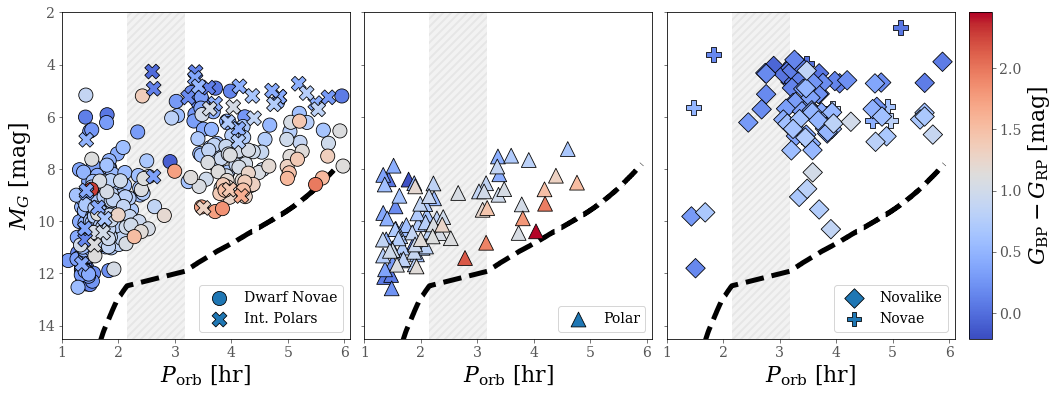

In [ ]:
fig, axes = plt.subplots(ncols=3, 
                         figsize=(16, 6), sharey=True, sharex=True)

color_mask = knigge_mask & (ug_mask | dq_mask | am_mask | nl_mask | nov_mask)

##------------
## Left Panel

knigge_mask = p_orb < 6

cb = axes[0].scatter(p_orb.loc[ug_mask & knigge_mask], 
                     abs_g.loc[ug_mask & knigge_mask], 
                     c=bp_rp.loc[ug_mask & knigge_mask], 
                     cmap='coolwarm', s=200,
                     alpha=1.0, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Dwarf Novae', zorder=1)

cb = axes[0].scatter(p_orb.loc[dq_mask & knigge_mask], 
                     abs_g.loc[dq_mask & knigge_mask], 
                     c=bp_rp.loc[dq_mask & knigge_mask], 
                     cmap='coolwarm', s=220, marker='X',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Int. Polars', zorder=4)

axes[0].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[0].axvspan(2.15, 3.18, alpha=0.1, color='#858585', hatch='///', lw=0, zorder=0)

axes[0].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[0].set_xlabel(r'$P_{\rm orb}$ [hr]')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(14.5, 2.0)
axes[0].set_xlim(1, 6.1)


##------------
## Middle Panel


cb = axes[1].scatter(p_orb.loc[am_mask & knigge_mask], 
                     abs_g.loc[am_mask & knigge_mask], 
                     c=bp_rp.loc[am_mask & knigge_mask], 
                     cmap='coolwarm', s=220, marker='^',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Polar', zorder=2)

axes[1].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[1].axvspan(2.15, 3.18, alpha=0.1, color='#858585', hatch='///', lw=0, zorder=0)

axes[1].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[1].set_xlabel(r'$P_{\rm orb}$ [hr]')


##------------
## Right Panel

swsex_names = swsex_df['name'].loc[(swsex_df['class_prob']=='definite') | (swsex_df['class_prob']=='probable')].values
# Possible DN misclassified
possible_dn = 'V5662 Sgr'
vyscl_mask = ((vsx_df['type'].str.contains('NL/VY')) & nl_mask)

cb = axes[2].scatter(p_orb.loc[nl_mask & knigge_mask], 
                     abs_g.loc[nl_mask & knigge_mask], 
                     c=bp_rp.loc[nl_mask & knigge_mask], 
                     cmap='coolwarm', s=190, marker='D',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Novalike', zorder=2)

cb = axes[2].scatter(p_orb.loc[nov_mask & knigge_mask], 
                     abs_g.loc[nov_mask & knigge_mask], 
                     c=bp_rp.loc[nov_mask & knigge_mask], 
                     cmap='coolwarm', s=220, marker='P',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Novae', zorder=1)

axes[2].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[2].axvspan(2.15, 3.18, alpha=0.1, color='#858585', hatch='///', lw=0, zorder=0)

axes[2].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[2].set_xlabel(r'$P_{\rm orb}$ [hr]')

cbar_ax = fig.add_axes([0.9125, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cb, cax=cbar_ax, label=r"$G_{\rm BP}-G_{\rm RP}$ [mag]")
cbar.set_ticks(np.arange(0,2.5,0.5))
cbar.set_ticklabels(np.arange(0,2.5,0.5))

plt.subplots_adjust(wspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/knigge_by_type.pdf', bbox_inches = 'tight', pad_inches = 0.15)

In [ ]:
zcam_mask = ((vsx_df['type'].str.contains('UGZ')) & ug_mask)
ugss_mask = ((vsx_df['type'].str.contains('UGSS')) & ug_mask)
ugsu_mask = ((vsx_df['type'].str.contains('UGSU') | 
              vsx_df['type'].str.contains('UGER') | 
              vsx_df['type'].str.contains('UGWZ')) & ug_mask)

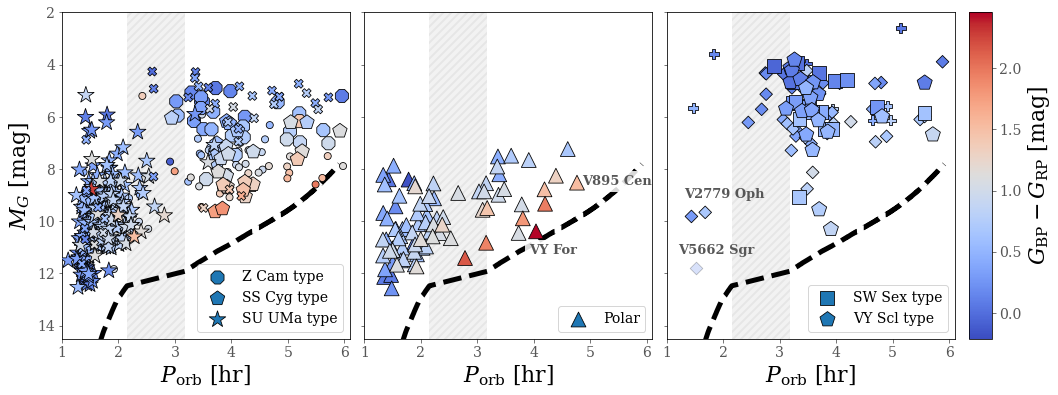

In [ ]:
fig, axes = plt.subplots(ncols=3, 
                         figsize=(16, 6), sharey=True, sharex=True)

color_mask = knigge_mask & (ug_mask | dq_mask | am_mask | nl_mask | nov_mask)

##------------
## Left Panel

knigge_mask = p_orb < 6

cb = axes[0].scatter(p_orb.loc[ug_mask & knigge_mask & ~(zcam_mask | ugss_mask | ugsu_mask)], 
                     abs_g.loc[ug_mask & knigge_mask & ~(zcam_mask | ugss_mask | ugsu_mask)], 
                     c=bp_rp.loc[ug_mask & knigge_mask & ~(zcam_mask | ugss_mask | ugsu_mask)], 
                     cmap='coolwarm', s=200, marker='.',
                     alpha=1.0, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='', zorder=2)

cb = axes[0].scatter(p_orb.loc[zcam_mask & knigge_mask & ~(ugss_mask | ugsu_mask)], 
                     abs_g.loc[zcam_mask & knigge_mask & ~(ugss_mask | ugsu_mask)], 
                     c=bp_rp.loc[zcam_mask & knigge_mask & ~(ugss_mask | ugsu_mask)], 
                     cmap='coolwarm', s=200, marker='8',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Z Cam type', zorder=3)

cb = axes[0].scatter(p_orb.loc[ugss_mask & knigge_mask], 
                     abs_g.loc[ugss_mask & knigge_mask], 
                     c=bp_rp.loc[ugss_mask & knigge_mask], 
                     cmap='coolwarm', s=230, marker='p',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='SS Cyg type', zorder=4)

cb = axes[0].scatter(p_orb.loc[ugsu_mask & knigge_mask], 
                     abs_g.loc[ugsu_mask & knigge_mask], 
                     c=bp_rp.loc[ugsu_mask & knigge_mask], 
                     cmap='coolwarm', s=300, marker='*',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='SU UMa type', zorder=5)

cb = axes[0].scatter(p_orb.loc[dq_mask & knigge_mask], 
                     abs_g.loc[dq_mask & knigge_mask], 
                     c=bp_rp.loc[dq_mask & knigge_mask], 
                     cmap='coolwarm', s=80, marker='X',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='', zorder=6)

axes[0].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[0].axvspan(2.15, 3.18, alpha=0.1, color='#858585', hatch='///', lw=0, zorder=0)

axes[0].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[0].set_xlabel(r'$P_{\rm orb}$ [hr]')
axes[0].set_ylabel('$M_G$ [mag]')
axes[0].set_ylim(14.5, 2.0)
axes[0].set_xlim(1, 6.1)


##------------
## Middle Panel


cb = axes[1].scatter(p_orb.loc[am_mask & knigge_mask], 
                     abs_g.loc[am_mask & knigge_mask], 
                     c=bp_rp.loc[am_mask & knigge_mask], 
                     cmap='coolwarm', s=220, marker='^',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='Polar', zorder=2)

axes[1].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

t = axes[1].annotate(f'VY For', (3.92, 11.25), fontweight='bold',
                     fontsize=13, c='#575757', zorder=1)
t.set_bbox(dict(facecolor='white', alpha=0.85, edgecolor='None'))

t = axes[1].annotate(f'V895 Cen', (4.85, 8.6), fontweight='bold',
                     fontsize=13, c='#575757', zorder=1)
t.set_bbox(dict(facecolor='white', alpha=0.85, edgecolor='None'))

axes[1].axvspan(2.15, 3.18, alpha=0.1, color='#858585', hatch='///', lw=0, zorder=0)

axes[1].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[1].set_xlabel(r'$P_{\rm orb}$ [hr]')


##------------
## Right Panel

swsex_names = swsex_df['name'].loc[(swsex_df['class_prob']=='definite') | (swsex_df['class_prob']=='probable')].values
# Possible DN misclassified
possible_dn = 'V5662 Sgr'
vyscl_mask = ((vsx_df['type'].str.contains('NL/VY')) & nl_mask)

cb = axes[2].scatter(p_orb.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                               (~vsx_df['name'].isin(swsex_names)) & ~vyscl_mask], 
                     abs_g.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                               (~vsx_df['name'].isin(swsex_names)) & ~vyscl_mask], 
                     c=bp_rp.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                                 (~vsx_df['name'].isin(swsex_names)) & ~vyscl_mask], 
                     cmap='coolwarm', s=80, marker='D',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='', zorder=2)

cb = axes[2].scatter(p_orb.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                               (vsx_df['name'].isin(swsex_names))], 
                     abs_g.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                               (vsx_df['name'].isin(swsex_names))], 
                     c=bp_rp.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                                 (vsx_df['name'].isin(swsex_names))], 
                     cmap='coolwarm', s=190, marker='s',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='SW Sex type', zorder=3)

cb = axes[2].scatter(p_orb.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                               vyscl_mask & (~vsx_df['name'].isin(swsex_names))], 
                     abs_g.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                               vyscl_mask & (~vsx_df['name'].isin(swsex_names))], 
                     c=bp_rp.loc[nl_mask & knigge_mask & (vsx_df['name'] != possible_dn) &
                                 vyscl_mask & (~vsx_df['name'].isin(swsex_names))], 
                     cmap='coolwarm', s=250, marker='p',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='VY Scl type', zorder=3)

cb = axes[2].scatter(p_orb.loc[(vsx_df['name'] == possible_dn)], 
                     abs_g.loc[(vsx_df['name'] == possible_dn)], 
                     c=bp_rp.loc[(vsx_df['name'] == possible_dn)], 
                     cmap='coolwarm', s=80, marker='D',
                     alpha=0.25, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='', zorder=4)

axes[2].annotate(f'{possible_dn}', (1.2, 11.25), fontweight='bold',
                 fontsize=13, c='#575757')

axes[2].annotate(f'V2779 Oph', (1.3, 9.1), fontweight='bold',
                 fontsize=13, c='#575757')

cb = axes[2].scatter(p_orb.loc[nov_mask & knigge_mask], 
                     abs_g.loc[nov_mask & knigge_mask], 
                     c=bp_rp.loc[nov_mask & knigge_mask], 
                     cmap='coolwarm', s=100, marker='P',
                     alpha=1, edgecolor='k', linewidth=0.8,
                     vmin=min(bp_rp.loc[color_mask]), 
                     vmax=max(bp_rp.loc[color_mask]),
                     label='', zorder=1)

axes[2].plot(donor_seq['Period'], donor_seq_g, 
             c='k', linewidth=5, linestyle='--', zorder=0)

axes[2].axvspan(2.15, 3.18, alpha=0.1, color='#858585', hatch='///', lw=0, zorder=0)

axes[2].legend(loc='lower right', prop={'size': 14}).set_zorder(20)

axes[2].set_xlabel(r'$P_{\rm orb}$ [hr]')

cbar_ax = fig.add_axes([0.9125, 0.125, 0.02, 0.755])
cbar = fig.colorbar(cb, cax=cbar_ax, label=r"$G_{\rm BP}-G_{\rm RP}$ [mag]")
cbar.set_ticks(np.arange(0,2.5,0.5))
cbar.set_ticklabels(np.arange(0,2.5,0.5))

plt.subplots_adjust(wspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/knigge_by_subtype.pdf', bbox_inches = 'tight', pad_inches = 0.15)

In [ ]:
vsx_df[['name', 'bp_rp', 'ra', 'dec']].loc[ugsu_mask & (bp_rp > 2.0)]

name     bp_rp          ra        dec
621  V0453 Nor  2.279652  240.197687 -48.768118

What are the VY Scl that are faintest?

In [ ]:
vsx_df[['name', 'bp_rp', 'ra', 'dec']].loc[vyscl_mask & (abs_g > 9.5)]

name     bp_rp          ra        dec
1045  V0704 And  0.754198  356.239753  43.522867
223      KR Aur  0.869905   93.933023  28.585673

In [ ]:
vsx_df[['name', 'bp_rp', 'ra', 'dec']].loc[vyscl_mask & (abs_g > 9)]

name     bp_rp          ra        dec
108      WX Ari  0.678637   41.900964  10.593739
1045  V0704 And  0.754198  356.239753  43.522867
223      KR Aur  0.869905   93.933023  28.585673

Looking at the color distribution of DN by subtype above and below 3.18 hr. https://www.aavso.org/vsx/index.php?view=about.vartypes

In [ ]:
vsx_df['type'].loc[vsx_df['type'].str.contains('UG')].unique()

array(['UG', 'UG+R', 'UGER', 'UG+E', 'UGZ/IW', 'UGWZ+ZZ/GWLIB', 'UGWZ',
       'UG/DQ+VY', 'UGSU+E', 'UGZ', 'UGWZ+E+ZZ/GWLIB', 'UGZ/IW+VY',
       'UGWZ+E+ZZ', 'UGZ/IW+UGSU', 'UGZ+VY', 'UGWZ+ZZ', 'UGSU+UGZ',
       'UGSU', 'UGWZ+E', 'UG/DQ', 'UGSU/DQ+E', 'UGER+E', 'UGZ+E',
       'UG/DQ+E', 'UGWZ/DQ+E+ZZ/GWLIB', 'UGSS', 'UGZ/IW+E', 'UGSU/DQ',
       'UGSS+E', 'UGSS+ELL', 'NA+UG', 'UGZ|NL+E', 'UGZ+N', 'UG+NL/VY',
       'UGSS+ZZ', 'UG+EW/WD'], dtype=object)

The three main classes of DN are `UGSU` (SU UMa, includes `UGER`, `UGWZ`), `UGSS` (SS Cygni), `UGZ` (Z Cam, includes `UGZ/IW`). 

- SU UMa types are the shortest period types and normal, short outbursts are similar to those of UGSS stars, while super-outbursts are brighter by 2 mag., are more than five times longer (wider), and occur several times less frequently.
- SS Cygni types and they increase in brightness by 2-6 mag. in V in 1-2 days and in several subsequent days return to their original brightnesses.
- Z Cam types also show cyclic outbursts, differing from UGSS variables by the fact that sometimes after an outburst they do not return to the original brightness, but during several cycles retain a magnitude between maximum and minimum. They are thought to have high accretion rates. https://arxiv.org/pdf/2106.15028.pdf

In [ ]:
zcam_mask = ((vsx_df['type'].str.contains('UGZ')) & ug_mask)
ugss_mask = ((vsx_df['type'].str.contains('UGSS')) & ug_mask)
ugsu_mask = ((vsx_df['type'].str.contains('UGSU') | 
              vsx_df['type'].str.contains('UGER') | 
              vsx_df['type'].str.contains('UGWZ')) & ug_mask)

In [ ]:
from scipy.stats import gaussian_kde

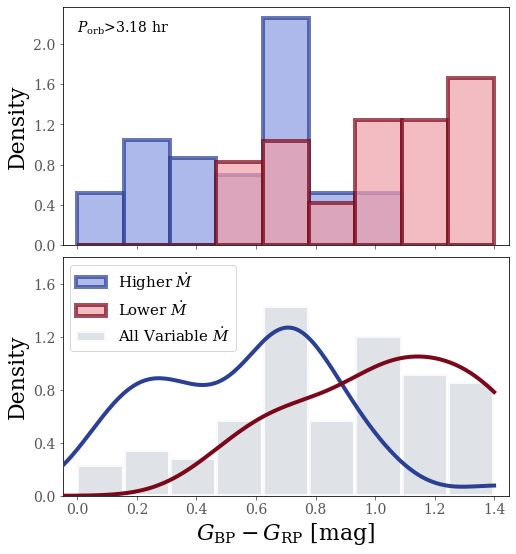

In [ ]:
fig, axes = plt.subplots(nrows=2, 
                         figsize=(8, 9), sharex=True)

### Upper Plot ###

axes[0].annotate(r'$P_{\rm orb}$>3.18 hr', (0.0, 2.12),
                 fontsize=14, c='k')

axes[0].hist(bp_rp.loc[zcam_mask & (p_orb > 3.18)], fc='#8a9be3', ec='#2b3f93', 
             alpha=0.7, density=True, lw=4, label=r'Higher $\dot{M}$',
             bins=np.linspace(0,1.4,10))

axes[0].hist(bp_rp.loc[(ugss_mask) & (p_orb > 3.18)], 
             fc='#ef9ea9', ec='#7b081a', 
             alpha=0.7, density=True, lw=4, label=r'Lower $\dot{M}$',
             bins=np.linspace(0,1.4,10))

# axes[0].hist(bp_rp.loc[ugsu_mask & (p_orb > 3.18)], fc='Lime', ec='Green', 
#              alpha=0.7, lw=4, label='SU UMa type',
#              bins=np.linspace(0,1.4,14))

### Lower Plot ###

zcam_density = gaussian_kde(bp_rp.loc[zcam_mask & (p_orb > 3.18)], bw_method=0.45)
ugss_density = gaussian_kde(bp_rp.loc[(ugss_mask) & (p_orb > 3.18)], 
                            bw_method=0.45)
ug_density = gaussian_kde(bp_rp.loc[ug_mask & (p_orb > 3.18)], bw_method=0.45)
xs = np.linspace(-0.3,1.4,200)

axes[1].hist(bp_rp.loc[ug_mask & (p_orb > 3.18)], fc='#d7dce3', ec='white', 
             alpha=0.8, density=True, lw=4, label=r'All Variable $\dot{M}$',
             bins=np.linspace(0,1.4,10), zorder=0)

# axes[1].plot(xs,ug_density(xs), c='#85898f', 
#              lw=4, zorder=21)
axes[1].plot(xs,zcam_density(xs), c='#2b3f93', 
             lw=4, zorder=22)
axes[1].plot(xs,ugss_density(xs), c='#7b081a', 
             lw=4, zorder=23)

handles, labels = [(a + b) for a, b in zip(axes[0].get_legend_handles_labels(), 
                                           axes[1].get_legend_handles_labels(),)]
axes[1].legend(handles, labels, loc='upper left', prop={'size': 15})

axes[0].set_ylabel('Density')
axes[0].set_yticks(np.arange(0,2.2, 0.4))
axes[1].set_ylabel('Density')
# axes[2].set_ylabel('Density')
axes[1].set_xlim(-0.05,1.45)
axes[1].set_ylim(0,1.8)
axes[1].set_yticks(np.arange(0,1.8, 0.4))
axes[1].set_xlabel(r'$G_{\rm BP} - G_{\rm RP}$ [mag]')

plt.subplots_adjust(hspace=0.05)

plt.savefig('/content/drive/MyDrive/cv_paper/figures/dn_distribution.pdf', bbox_inches = 'tight', pad_inches = 0.15)

## Making a LaTeX Table for the Paper

First, make the RK16-*Gaia* crossmatch table.

In [ ]:
vsx_df.columns

Index(['name', 'type', 'period', 'u_period', 'solution_id', 'designation',
       'source_id', 'random_index', 'ref_epoch', 'ra',
       ...
       'dr2_phot_g_mean_mag', 'dr2_bp_rp', 'dr2_phot_g_mean_flux_error',
       'dr2_phot_g_mean_flux', 'dr2_phot_bp_mean_flux_error',
       'dr2_phot_bp_mean_flux', 'dr2_phot_rp_mean_flux_error',
       'dr2_phot_rp_mean_flux', 'dr2_phot_bp_n_obs', 'gen_type'],
      dtype='object', length=116)

In [ ]:
vsxdf_table = pd.DataFrame({'{\it Gaia} \texttt{source\_id}': vsx_df['source_id'], 
                            '{\it Gaia 2} \texttt{source\_id}': vsx_df['dr2_source_id'], 
                            '\hyperlink{cite.watson_2006}{VSX} Name': vsx_df['name'],
                            '$P_{\rm orb}$': p_orb, '$M_G$': abs_g, 
                            '$G_{\rm BP}-G_{\rm RP}$': bp_rp}).round(decimals=4)

vsxdf_table.sort_values(by='$P_{\rm orb}$', inplace=True)

In [ ]:
vsx_table = Table.from_pandas(vsxdf_table)
vsx_table.write('/content/drive/MyDrive/cv_paper/figures/vsx_xmatch_table.dat', format='ascii.aastex', overwrite=True)

Print out EDR3 and DR2 parameter fits to put into Table 2.

In [ ]:
with edr3_model:
    display(az.summary(edr3_trace, hdi_prob = 0.90, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                                        'beta_xterm', 'sigma'], :])

mean     sd  hdi_5%  hdi_95%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept   2.548  0.132   2.337    2.765  ...    0.003  1350.194  3552.427  1.004
beta_absg  -1.272  0.060  -1.370   -1.176  ...    0.001  1579.698  4148.495  1.004
beta_bprp   0.834  0.056   0.739    0.923  ...    0.001  1503.599  2271.761  1.004
beta_xterm -0.445  0.058  -0.536   -0.348  ...    0.001  1722.050  3036.584  1.004
sigma       0.109  0.012   0.089    0.129  ...    0.000   374.773   180.121  1.008

[5 rows x 9 columns]

In [ ]:
with dr2_model:
    display(az.summary(dr2_trace, hdi_prob = 0.90, round_to=3).loc[['intercept', 'beta_absg', 'beta_bprp', 
                                                                        'beta_xterm', 'sigma'], :])

mean     sd  hdi_5%  hdi_95%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
intercept   2.709  0.143   2.483    2.950  ...    0.002  4319.857  8429.521  1.001
beta_absg  -1.312  0.060  -1.411   -1.215  ...    0.001  4522.500  8581.350  1.001
beta_bprp   0.757  0.056   0.663    0.848  ...    0.001  2843.988  2962.493  1.002
beta_xterm -0.385  0.057  -0.481   -0.295  ...    0.001  3096.696  4448.594  1.001
sigma       0.108  0.012   0.088    0.128  ...    0.000  1967.281  1669.035  1.003

[5 rows x 9 columns]

Finally, we make the table for figure 7. To do so, we isolate the CVs that have a subtype in the VSX.

In [ ]:
type_table = pd.DataFrame({'{\it Gaia} \texttt{source\_id}': vsx_df['source_id'], 
                           '\hyperlink{cite.watson_2006}{VSX} Type': vsx_df['gen_type'],
                           '$P_{\rm orb}$': p_orb, '$M_G$': abs_g, 
                           '$G_{\rm BP}-G_{\rm RP}$': bp_rp}).loc[vsx_df['gen_type'] != 0.0].round(decimals=4)

type_table.sort_values(by='\hyperlink{cite.watson_2006}{VSX} Type', inplace=True)

In [ ]:
type_table.loc[type_table['\hyperlink{cite.watson_2006}{VSX} Type']=='CN']

{\it Gaia} \texttt{source\_id} \hyperlink{cite.watson_2006}{VSX} Type  \
786             4506083222318688000                                     CN   
235             5477422099543150592                                     CN   
983             2006109065688505472                                     CN   
379             5628258258606112768                                     CN   
898             1813953083546374144                                     CN   
193             3446266197646225536                                     CN   
740             2116226254706461568                                     CN   
823             2017742684676480896                                     CN   
748             2113091615775375232                                     CN   
331             5544760551021856000                                     CN   
138             4731746232846281344                                     CN   
574             5891405647833287296                                     CN   

     $P_{\rm orb}$   $M_G$  $G_{\rm BP}-G_{\rm RP}$  
786         4.9680  6.1319                   0.8006  
235         3.4806  3.9655                   0.0126  
983         3.4834  5.3991                   0.4171  
379         1.8295  3.5979                   0.1734  
898         5.1400  2.5927                   0.0536  
193         4.9051  5.5899                   0.6395  
740         4.6469  6.1332                   0.4617  
823         3.5160  6.9495                   1.5932  
748         3.5280  4.5804                   0.1104  
331         1.4700  5.6577                   0.4952  
138         3.1789  4.2318                   0.0769  
574         3.9360  5.6924                   0.7903

In [ ]:
type_table = Table.from_pandas(type_table)
type_table.write('/content/drive/MyDrive/cv_paper/figures/vsx_type_table.dat', format='ascii.aastex', overwrite=True)